# Proyecto: Reconocimiento de Lenguaje de Señas Americano (ASL)

## Notebook 02: Análisis Exploratorio de Datos (EDA)

**Objetivo:** Realizar un análisis profundo y detallado del dataset para comprender sus características, patrones, desafíos y oportunidades.

Este notebook incluye:
- Análisis de distribución y balance de clases
- Estadísticas descriptivas de pixels
- Análisis de variabilidad intra-clase e inter-clase
- Visualización de imágenes representativas
- Reducción dimensional (PCA, t-SNE)
- Análisis de características visuales
- Detección de outliers y anomalías
- Análisis de similitud entre clases

---

## 0. Configuración e Importación de Librerías

In [2]:
# Importaciones estándar
import os
import sys
import json
import warnings
warnings.filterwarnings('ignore')

# Procesamiento de datos
import numpy as np
import pandas as pd

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Procesamiento de imágenes
import cv2
from scipy import stats, ndimage
from skimage import feature, filters, exposure

# Machine Learning
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import dendrogram, linkage

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Configuración de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Librerías importadas correctamente")

Librerías importadas correctamente


## 1. Carga de Datos y Configuración de Rutas

In [16]:
# Detectar si estamos en Colab o local
try:
    from google.colab import files
    IN_COLAB = True
    BASE_DIR = '/content/sign_language_project'
except:
    IN_COLAB = False
    BASE_DIR = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))

# Definir rutas
DATA_RAW = os.path.join(BASE_DIR, 'data', 'raw')
DATA_PROCESSED = os.path.join(BASE_DIR, 'data', 'processed')
FIGURES_DIR = os.path.join(BASE_DIR, 'results', 'figures')
REPORTS_DIR = os.path.join(BASE_DIR, 'results', 'reports')

# Cargar datos
train_df = pd.read_csv(os.path.join(DATA_RAW, 'sign_mnist_train.csv'))
test_df = pd.read_csv(os.path.join(DATA_RAW, 'sign_mnist_test.csv'))

# Cargar metadatos
with open(os.path.join(DATA_RAW, 'dataset_metadata.json'), 'r') as f:
    metadata = json.load(f)

# Mapeo de etiquetas a letras
label_to_letter = {int(k): v for k, v in metadata['label_mapping'].items()}
letter_to_label = {v: k for k, v in label_to_letter.items()}

# Obtener las etiquetas únicas válidas (0-8, 10-24, excluyendo 9)
valid_labels = sorted(label_to_letter.keys())

print(f"Datos de entrenamiento: {train_df.shape}")
print(f"Datos de prueba: {test_df.shape}")
print(f"Total de imágenes: {len(train_df) + len(test_df):,}")
print(f"Etiquetas válidas: {valid_labels}")

Datos de entrenamiento: (27455, 785)
Datos de prueba: (7172, 785)
Total de imágenes: 34,627
Etiquetas válidas: [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


## 2. Análisis de Distribución de Clases

### 2.1 Distribución General y Balance de Clases

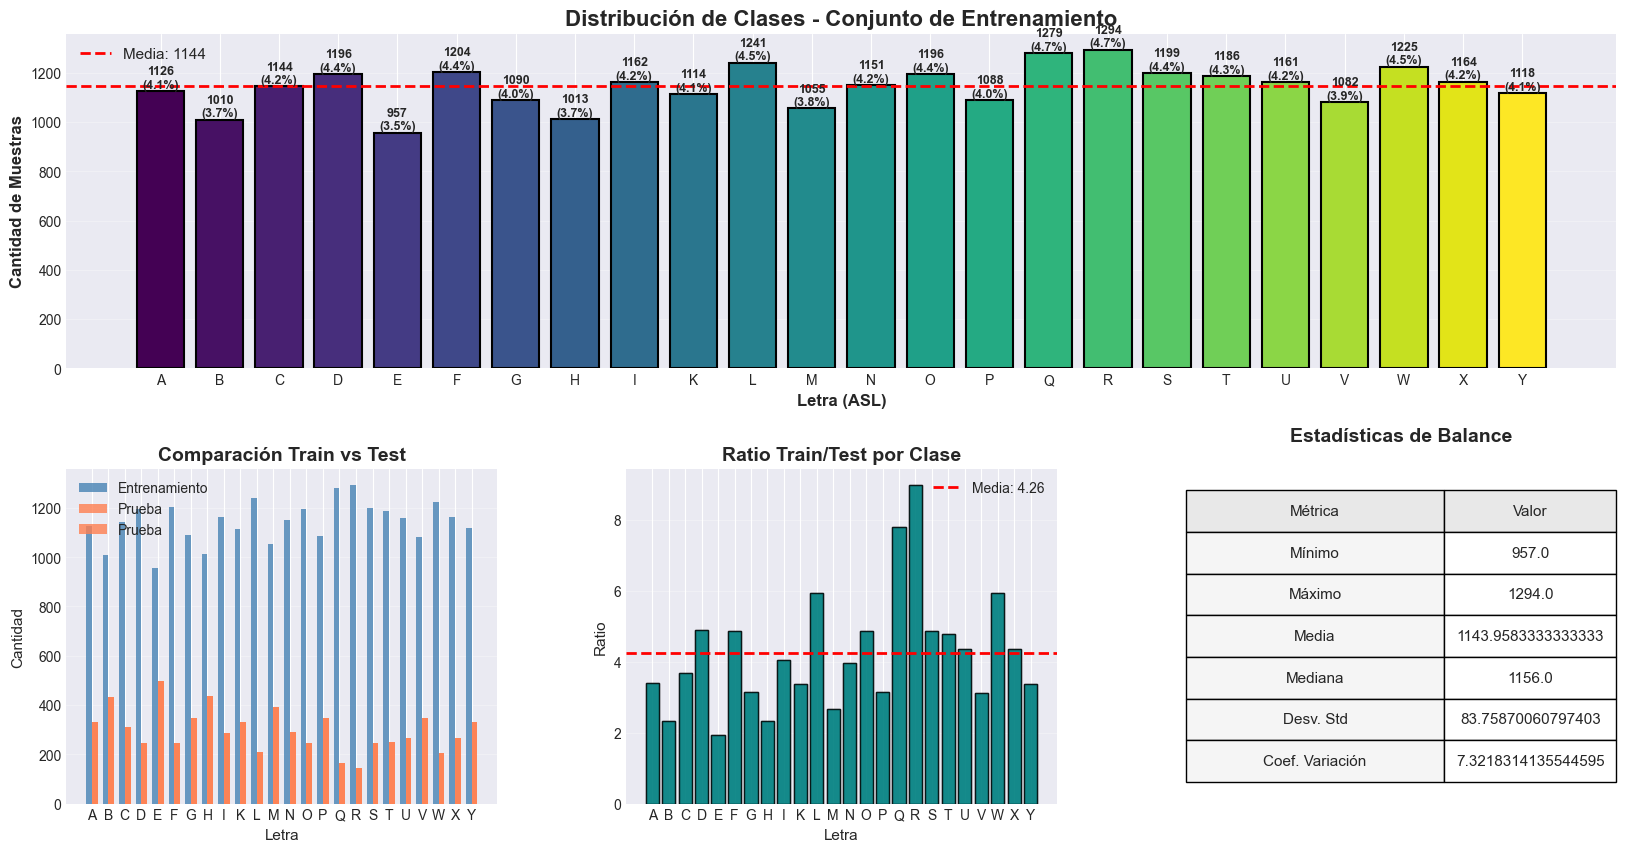


Coeficiente de Variación: 7.32%
El dataset está MUY BIEN BALANCEADO


In [17]:
# Análisis de balance
train_counts = train_df['label'].value_counts().sort_index()
test_counts = test_df['label'].value_counts().sort_index()

# Crear figura con subplots
fig = plt.figure(figsize=(20, 10))
gs = GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.3)

# Subplot 1: Distribución de entrenamiento
ax1 = fig.add_subplot(gs[0, :])
labels = train_counts.index.tolist()
letters = [label_to_letter[i] for i in labels]
bars = ax1.bar(letters, train_counts.values, color=plt.cm.viridis(np.linspace(0, 1, len(letters))), edgecolor='black', linewidth=1.5)
ax1.set_title('Distribución de Clases - Conjunto de Entrenamiento', fontsize=16, fontweight='bold')
ax1.set_xlabel('Letra (ASL)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Cantidad de Muestras', fontsize=12, fontweight='bold')
ax1.axhline(y=train_counts.mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {train_counts.mean():.0f}')
ax1.legend(fontsize=11)
ax1.grid(axis='y', alpha=0.3)

# Añadir valores y porcentajes encima de las barras
for i, (bar, count) in enumerate(zip(bars, train_counts.values)):
    height = bar.get_height()
    percentage = (count / len(train_df)) * 100
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{count}\n({percentage:.1f}%)',
            ha='center', va='bottom', fontsize=9, fontweight='bold')
# Subplot 2: Comparación Train vs Test
ax2 = fig.add_subplot(gs[1, 0])
x_pos = np.arange(len(letters))
width = 0.35
ax2.bar(x_pos - width/2, train_counts.reindex(labels).values, width, label='Entrenamiento', alpha=0.8, color='steelblue')
ax2.bar(x_pos + width/2, test_counts.reindex(labels).values, width, label='Prueba', alpha=0.8, color='coral')
ax2.bar(x_pos + width/2, test_counts.values, width, label='Prueba', alpha=0.8, color='coral')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(letters, rotation=0)
ax2.set_title('Comparación Train vs Test', fontsize=14, fontweight='bold')
ax2.set_xlabel('Letra', fontsize=11)
ax2.set_ylabel('Cantidad', fontsize=11)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)
# Subplot 3: Proporción Train/Test por clase
ax3 = fig.add_subplot(gs[1, 1])
ratios = train_counts.reindex(labels).values / test_counts.reindex(labels).values
ax3.bar(letters, ratios, color='teal', alpha=0.7, edgecolor='black')
ax3.bar(letters, ratios, color='teal', alpha=0.7, edgecolor='black')
ax3.axhline(y=ratios.mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {ratios.mean():.2f}')
ax3.set_title('Ratio Train/Test por Clase', fontsize=14, fontweight='bold')
ax3.set_xlabel('Letra', fontsize=11)
ax3.set_ylabel('Ratio', fontsize=11)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# Subplot 4: Estadísticas de balance
ax4 = fig.add_subplot(gs[1, 2])
balance_stats = pd.DataFrame({
    'Métrica': ['Mínimo', 'Máximo', 'Media', 'Mediana', 'Desv. Std', 'Coef. Variación'],
    'Valor': [
        train_counts.min(),
        train_counts.max(),
        train_counts.mean(),
        train_counts.median(),
        train_counts.std(),
        (train_counts.std() / train_counts.mean()) * 100
    ]
})
ax4.axis('tight')
ax4.axis('off')
table = ax4.table(cellText=balance_stats.values,
                 colLabels=balance_stats.columns,
                 cellLoc='center',
                 loc='center',
                 colWidths=[0.6, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)
for i in range(len(balance_stats) + 1):
    table[(i, 0)].set_facecolor('#E8E8E8' if i == 0 else '#F5F5F5')
    table[(i, 1)].set_facecolor('#E8E8E8' if i == 0 else '#FFFFFF')
ax4.set_title('Estadísticas de Balance', fontsize=14, fontweight='bold', pad=20)

plt.savefig(os.path.join(FIGURES_DIR, '02_distribucion_clases.png'), dpi=200, bbox_inches='tight')
plt.show()

# Evaluar balance del dataset
cv = (train_counts.std() / train_counts.mean()) * 100
print(f"\nCoeficiente de Variación: {cv:.2f}%")
if cv < 10:
    print("El dataset está MUY BIEN BALANCEADO")
elif cv < 20:
    print("El dataset está BIEN BALANCEADO")
elif cv < 30:
    print("El dataset está MODERADAMENTE BALANCEADO")
else:
    print("El dataset está DESBALANCEADO - considerar técnicas de balanceo")

### 2.2 Análisis de Proporciones y Test Chi-cuadrado

In [18]:
from scipy.stats import chi2_contingency, chisquare

# Test de chi-cuadrado para evaluar si la distribución es uniforme
expected_freq = len(train_df) / 24  # Frecuencia esperada si fuera uniforme
chi2_stat, p_value = chisquare(train_counts.values)

print("=" * 70)
print("TEST DE UNIFORMIDAD (Chi-cuadrado)")
print("=" * 70)
print(f"H0: La distribución de clases es uniforme")
print(f"H1: La distribución de clases NO es uniforme")
print(f"\nEstadístico Chi-cuadrado: {chi2_stat:.4f}")
print(f"P-valor: {p_value:.4e}")
print(f"\nConclusión: ", end="")
if p_value < 0.05:
    print("Rechazamos H0 - La distribución NO es uniforme (alpha=0.05)")
else:
    print("No rechazamos H0 - La distribución puede considerarse uniforme (alpha=0.05)")
print("=" * 70)

TEST DE UNIFORMIDAD (Chi-cuadrado)
H0: La distribución de clases es uniforme
H1: La distribución de clases NO es uniforme

Estadístico Chi-cuadrado: 141.0514
P-valor: 5.9154e-19

Conclusión: Rechazamos H0 - La distribución NO es uniforme (alpha=0.05)


## 3. Análisis Estadístico de Pixels

### 3.1 Estadísticas Descriptivas Globales

In [19]:
# Separar features y labels
X_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values
X_test = test_df.drop('label', axis=1).values
y_test = test_df['label'].values

# Estadísticas globales
print("=" * 70)
print("ESTADÍSTICAS DE INTENSIDAD DE PIXELS - CONJUNTO COMPLETO")
print("=" * 70)
print(f"Rango de valores: [{X_train.min():.0f}, {X_train.max():.0f}]")
print(f"Media global: {X_train.mean():.2f}")
print(f"Mediana global: {np.median(X_train):.2f}")
print(f"Desviación estándar: {X_train.std():.2f}")
print(f"Varianza: {X_train.var():.2f}")
print(f"Coeficiente de variación: {(X_train.std() / X_train.mean()) * 100:.2f}%")
print(f"\nAsimetría (Skewness): {stats.skew(X_train.flatten()):.4f}")
print(f"Curtosis: {stats.kurtosis(X_train.flatten()):.4f}")
print(f"\nPercentiles:")
for p in [5, 10, 25, 50, 75, 90, 95]:
    print(f"  P{p}: {np.percentile(X_train, p):.2f}")
print("=" * 70)

ESTADÍSTICAS DE INTENSIDAD DE PIXELS - CONJUNTO COMPLETO
Rango de valores: [0, 255]
Media global: 159.29
Mediana global: 167.00
Desviación estándar: 48.77
Varianza: 2378.46
Coeficiente de variación: 30.62%

Asimetría (Skewness): -0.6069
Curtosis: 0.0661

Percentiles:
  P5: 68.00
  P10: 89.00
  P25: 130.00
  P50: 167.00
  P75: 194.00
  P90: 215.00
  P95: 229.00


### 3.2 Distribución de Intensidades de Pixels

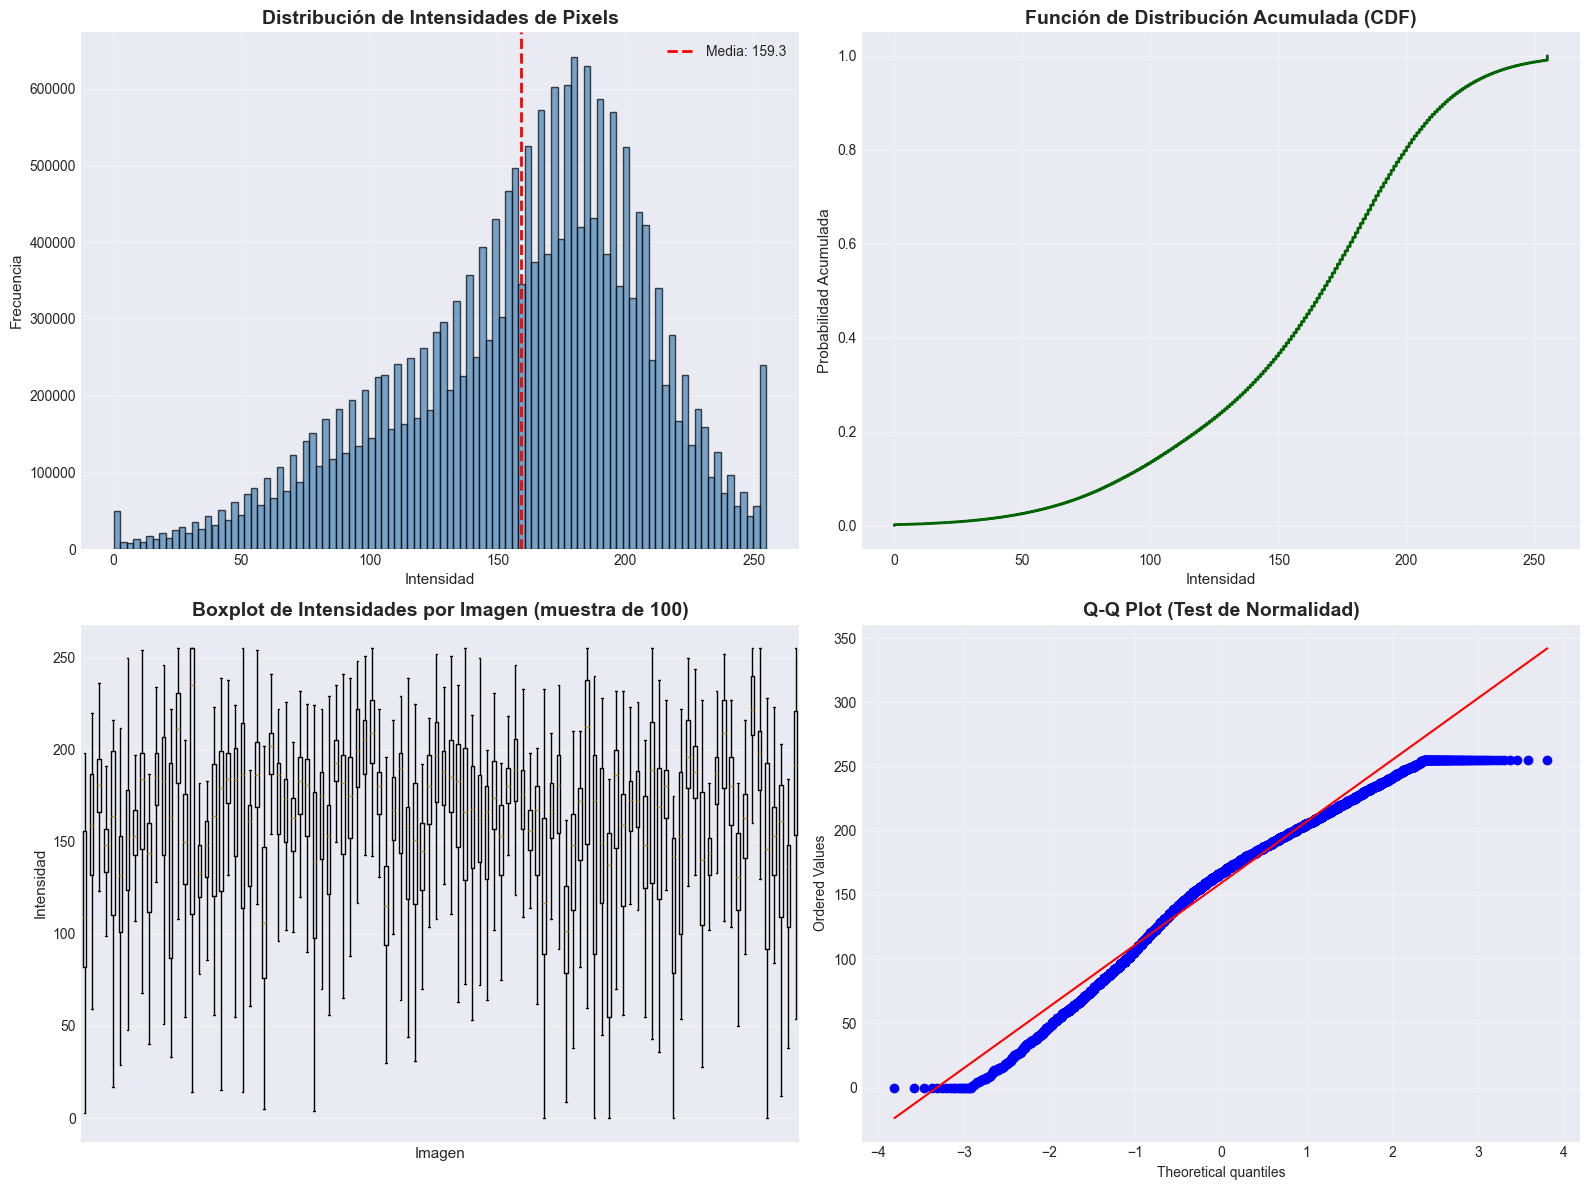

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Histograma de intensidades
axes[0, 0].hist(X_train.flatten(), bins=100, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Distribución de Intensidades de Pixels', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Intensidad', fontsize=11)
axes[0, 0].set_ylabel('Frecuencia', fontsize=11)
axes[0, 0].axvline(X_train.mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {X_train.mean():.1f}')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Distribución acumulada (CDF)
sorted_pixels = np.sort(X_train.flatten())
cdf = np.arange(1, len(sorted_pixels) + 1) / len(sorted_pixels)
axes[0, 1].plot(sorted_pixels, cdf, color='darkgreen', linewidth=2)
axes[0, 1].set_title('Función de Distribución Acumulada (CDF)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Intensidad', fontsize=11)
axes[0, 1].set_ylabel('Probabilidad Acumulada', fontsize=11)
axes[0, 1].grid(alpha=0.3)

# Boxplot de intensidades por imagen (muestra)
sample_size = 100
sample_indices = np.random.choice(len(X_train), sample_size, replace=False)
sample_data = X_train[sample_indices]
axes[1, 0].boxplot([row for row in sample_data], showfliers=False)
axes[1, 0].set_title(f'Boxplot de Intensidades por Imagen (muestra de {sample_size})', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Imagen', fontsize=11)
axes[1, 0].set_ylabel('Intensidad', fontsize=11)
axes[1, 0].set_xticks([])
axes[1, 0].grid(axis='y', alpha=0.3)

# Q-Q plot para normalidad
sample_pixels = np.random.choice(X_train.flatten(), 10000, replace=False)
stats.probplot(sample_pixels, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot (Test de Normalidad)', fontsize=14, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, '02_distribucion_pixels.png'), dpi=200, bbox_inches='tight')
plt.show()

### 3.3 Análisis de Varianza por Posición de Pixel

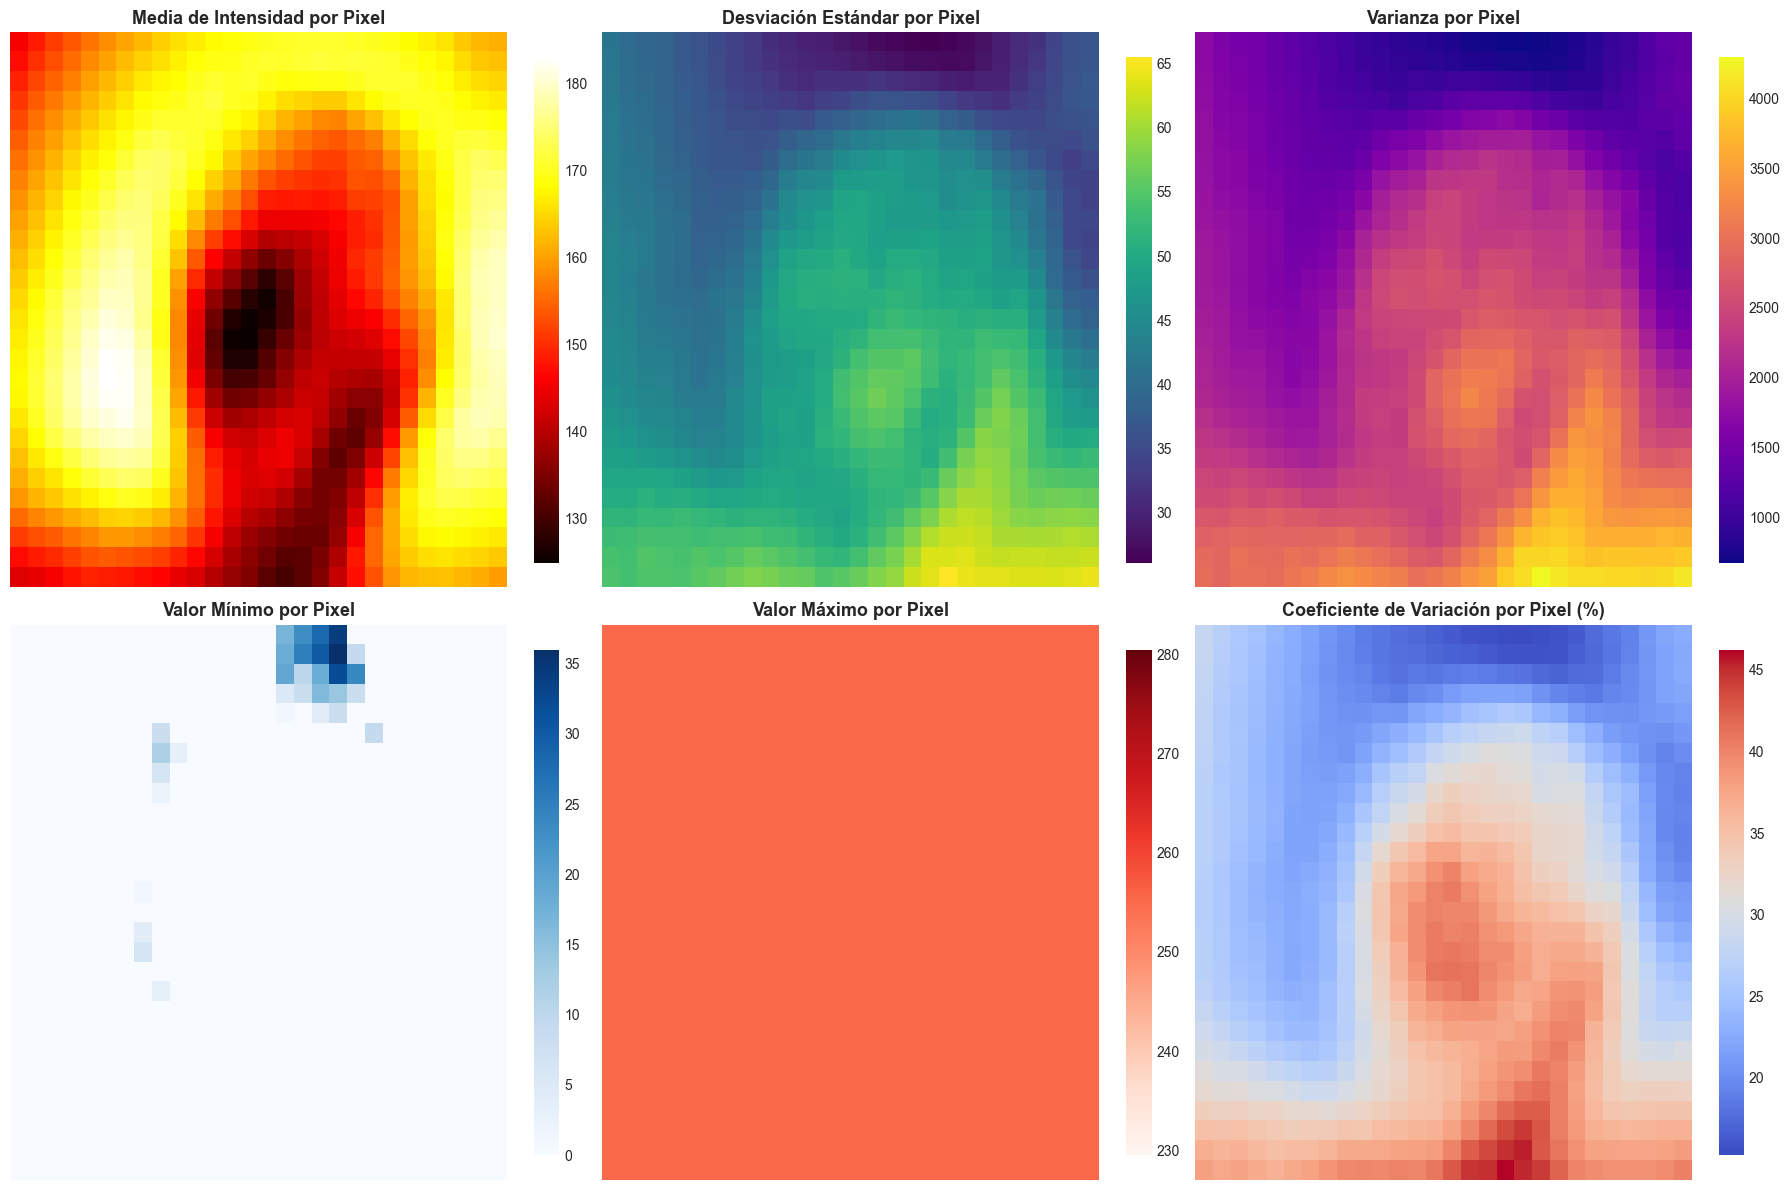


Interpretación:
- Pixels con alta varianza son más informativos (contienen más variabilidad entre clases)
- Pixels con baja varianza (bordes, esquinas) son menos útiles para clasificación
- Varianza media: 2181.10
- Varianza máxima: 4291.78
- Varianza mínima: 680.58


In [21]:
# Calcular estadísticas por posición de pixel
pixel_means = X_train.mean(axis=0).reshape(28, 28)
pixel_stds = X_train.std(axis=0).reshape(28, 28)
pixel_vars = X_train.var(axis=0).reshape(28, 28)
pixel_mins = X_train.min(axis=0).reshape(28, 28)
pixel_maxs = X_train.max(axis=0).reshape(28, 28)

# Visualizar
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Media por pixel
im1 = axes[0, 0].imshow(pixel_means, cmap='hot', aspect='auto')
axes[0, 0].set_title('Media de Intensidad por Pixel', fontsize=13, fontweight='bold')
plt.colorbar(im1, ax=axes[0, 0], fraction=0.046)

# Desviación estándar por pixel
im2 = axes[0, 1].imshow(pixel_stds, cmap='viridis', aspect='auto')
axes[0, 1].set_title('Desviación Estándar por Pixel', fontsize=13, fontweight='bold')
plt.colorbar(im2, ax=axes[0, 1], fraction=0.046)

# Varianza por pixel
im3 = axes[0, 2].imshow(pixel_vars, cmap='plasma', aspect='auto')
axes[0, 2].set_title('Varianza por Pixel', fontsize=13, fontweight='bold')
plt.colorbar(im3, ax=axes[0, 2], fraction=0.046)

# Mínimo por pixel
im4 = axes[1, 0].imshow(pixel_mins, cmap='Blues', aspect='auto')
axes[1, 0].set_title('Valor Mínimo por Pixel', fontsize=13, fontweight='bold')
plt.colorbar(im4, ax=axes[1, 0], fraction=0.046)

# Máximo por pixel
im5 = axes[1, 1].imshow(pixel_maxs, cmap='Reds', aspect='auto')
axes[1, 1].set_title('Valor Máximo por Pixel', fontsize=13, fontweight='bold')
plt.colorbar(im5, ax=axes[1, 1], fraction=0.046)

# Coeficiente de variación por pixel
pixel_cv = (pixel_stds / (pixel_means + 1e-8)) * 100
im6 = axes[1, 2].imshow(pixel_cv, cmap='coolwarm', aspect='auto')
axes[1, 2].set_title('Coeficiente de Variación por Pixel (%)', fontsize=13, fontweight='bold')
plt.colorbar(im6, ax=axes[1, 2], fraction=0.046)

for ax in axes.flat:
    ax.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, '02_estadisticas_por_pixel.png'), dpi=200, bbox_inches='tight')
plt.show()

print("\nInterpretación:")
print("- Pixels con alta varianza son más informativos (contienen más variabilidad entre clases)")
print("- Pixels con baja varianza (bordes, esquinas) son menos útiles para clasificación")
print(f"- Varianza media: {pixel_vars.mean():.2f}")
print(f"- Varianza máxima: {pixel_vars.max():.2f}")
print(f"- Varianza mínima: {pixel_vars.min():.2f}")

## 4. Análisis por Clase

### 4.1 Imágenes Promedio y Desviación Estándar por Clase

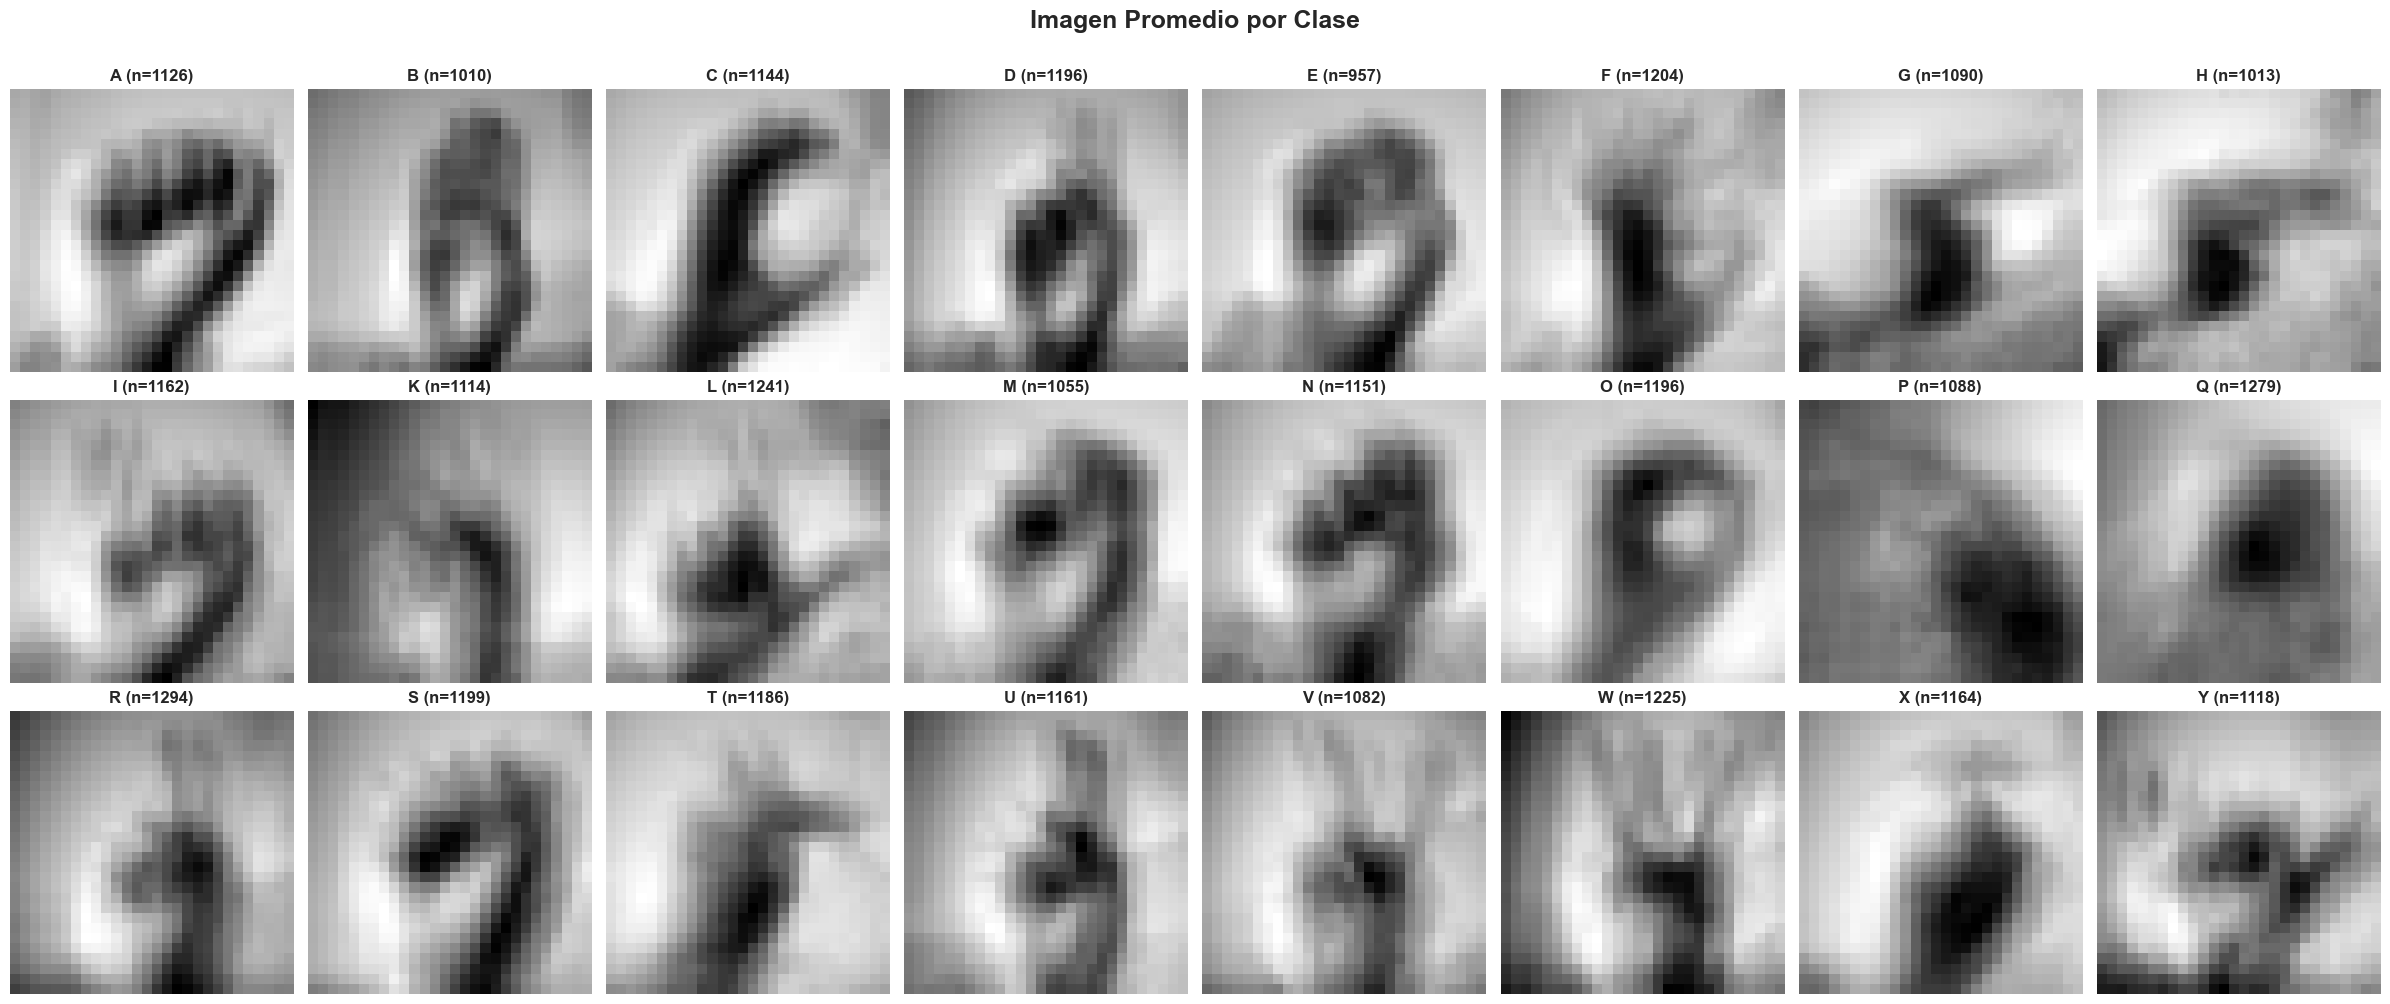

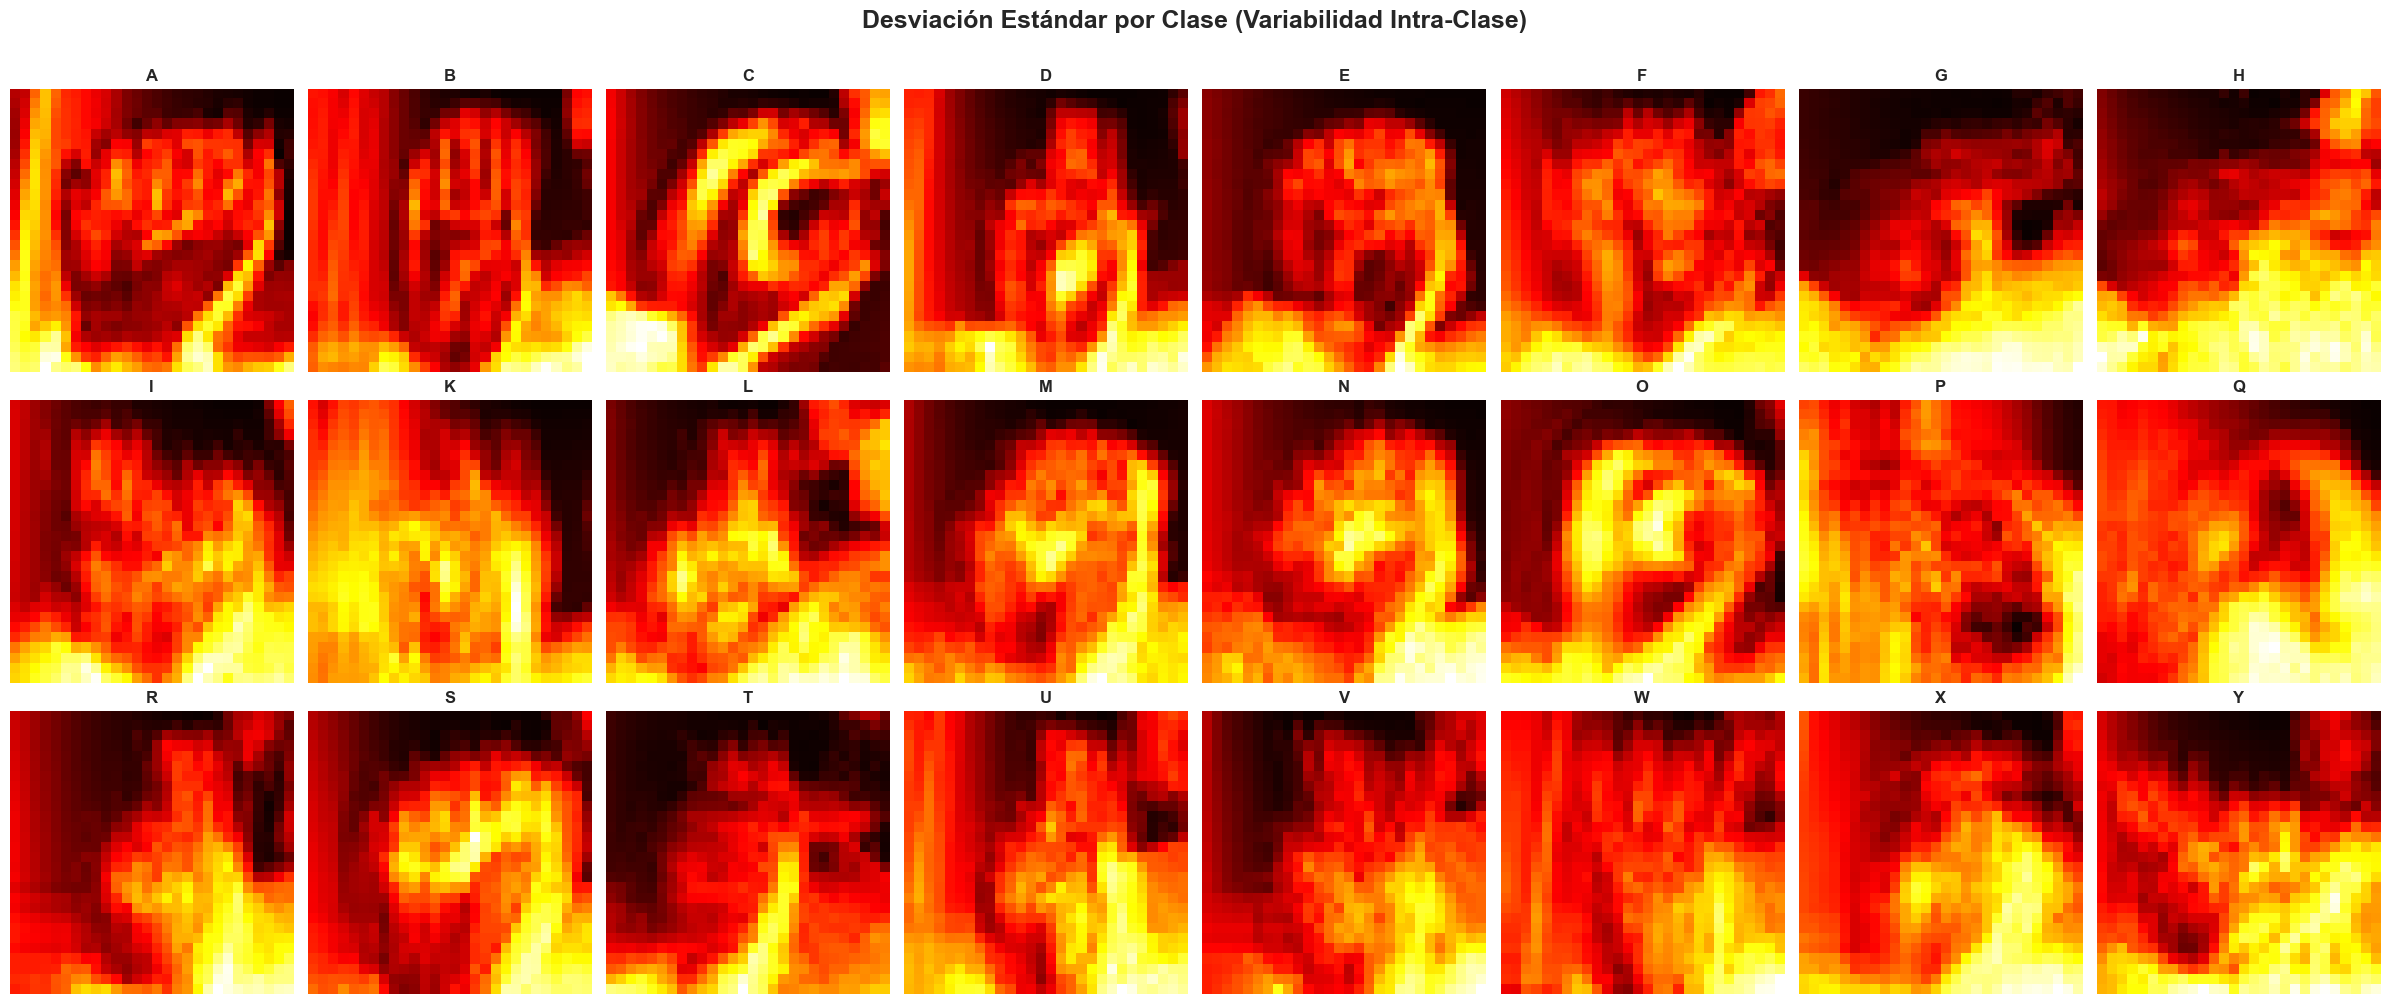

In [22]:
# Calcular imágenes promedio y desviación estándar por clase
fig, axes = plt.subplots(3, 8, figsize=(24, 10))
axes = axes.ravel()

class_labels = train_counts.index.tolist()

for i, class_label in enumerate(class_labels):
    # Filtrar imágenes de la clase
    class_images = X_train[y_train == class_label]
    
    # Calcular promedio
    avg_img = class_images.mean(axis=0).reshape(28, 28)
    
    # Visualizar
    axes[i].imshow(avg_img, cmap='gray')
    axes[i].set_title(f'{label_to_letter[class_label]} (n={len(class_images)})', fontsize=12, fontweight='bold')
    axes[i].axis('off')

plt.suptitle('Imagen Promedio por Clase', fontsize=18, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, '02_imagenes_promedio_por_clase.png'), dpi=200, bbox_inches='tight')
plt.show()

# Ahora desviación estándar
fig, axes = plt.subplots(3, 8, figsize=(24, 10))
axes = axes.ravel()

for i, class_label in enumerate(class_labels):
    class_images = X_train[y_train == class_label]
    std_img = class_images.std(axis=0).reshape(28, 28)
    
    im = axes[i].imshow(std_img, cmap='hot')
    axes[i].set_title(f'{label_to_letter[class_label]}', fontsize=12, fontweight='bold')
    axes[i].axis('off')

plt.suptitle('Desviación Estándar por Clase (Variabilidad Intra-Clase)', fontsize=18, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, '02_desviacion_por_clase.png'), dpi=200, bbox_inches='tight')
plt.show()

### 4.2 Estadísticas de Intensidad por Clase

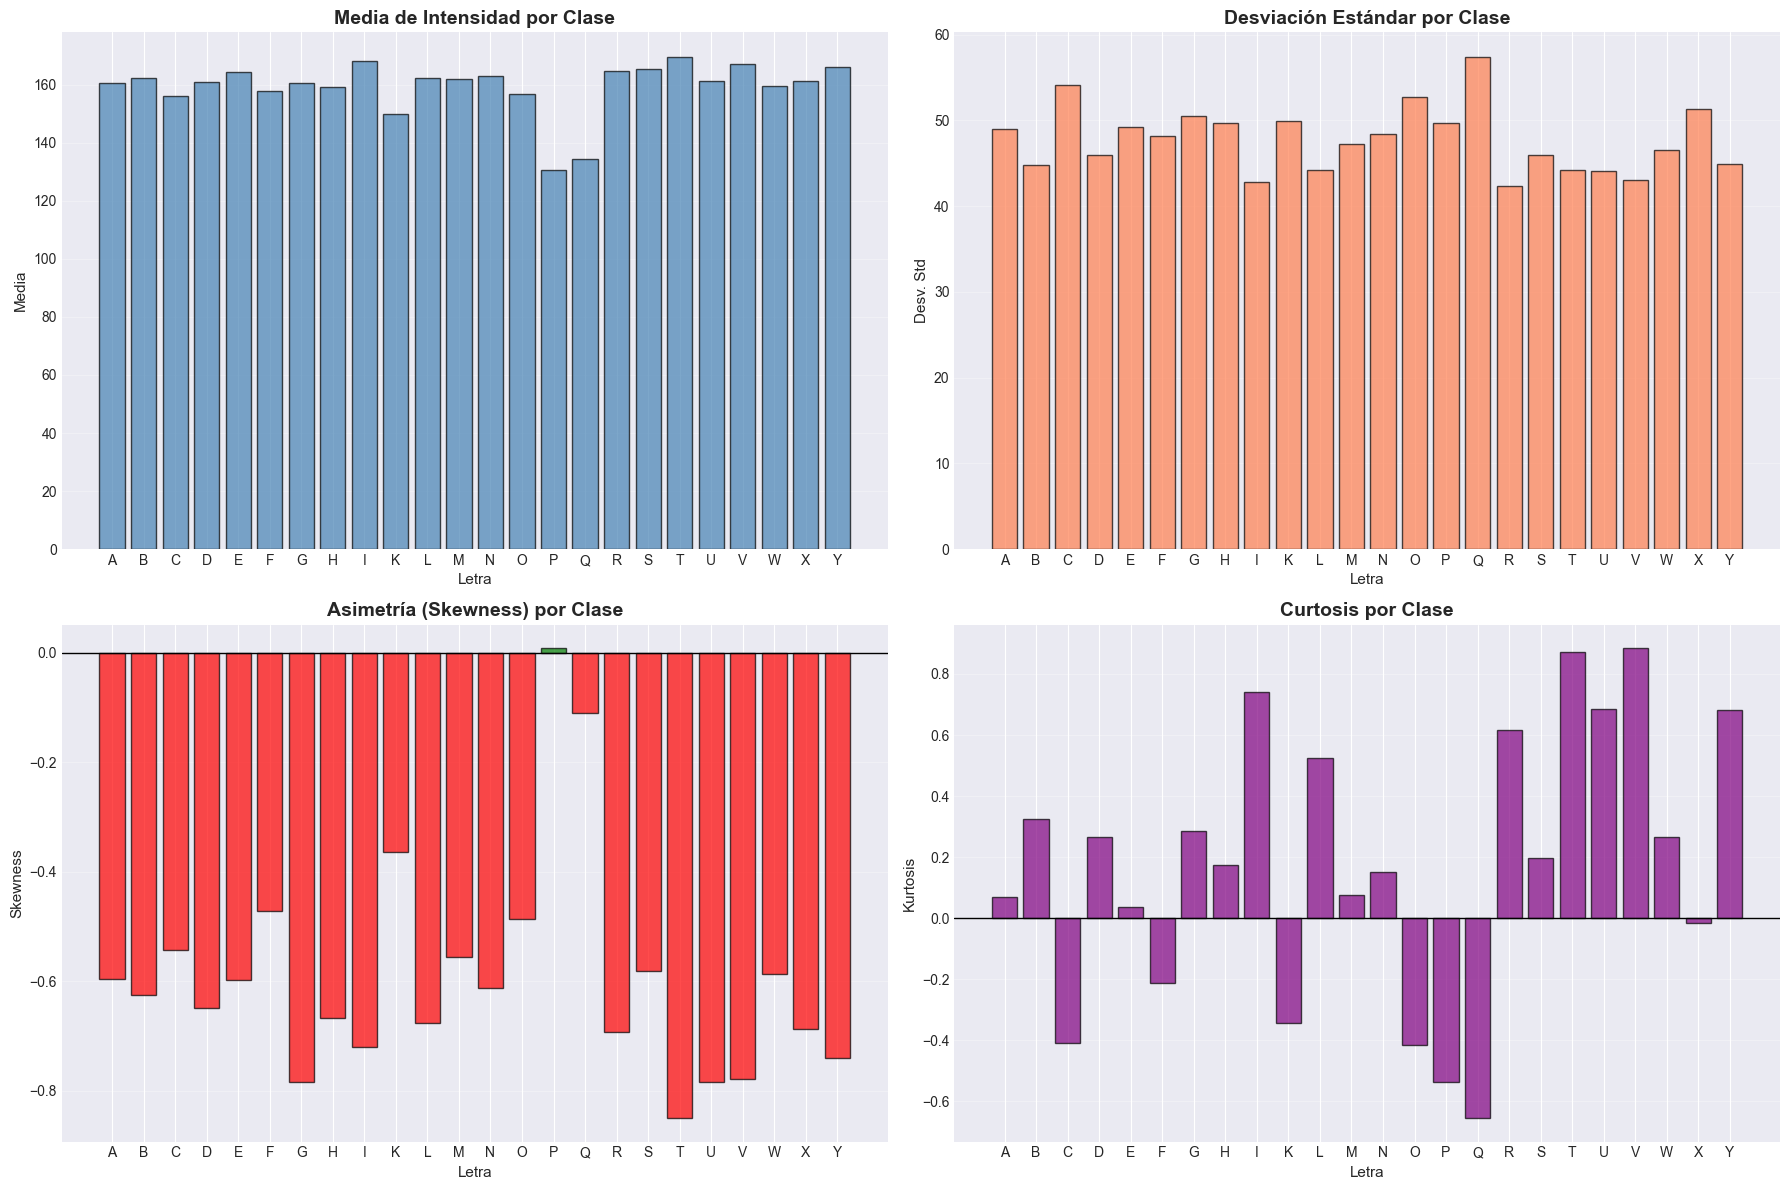


ESTADÍSTICAS DE INTENSIDAD POR CLASE
Letra      Media  Mediana  Desv_Std    Varianza  Min  Max    Q1    Q3  Skewness  Kurtosis
    A 160.600040    168.0 48.935257 2394.659422    0  255 131.0 195.0 -0.595310  0.069386
    B 162.177958    169.0 44.786258 2005.808880    0  255 136.0 194.0 -0.624399  0.323850
    C 156.042430    168.0 54.119411 2928.910617    0  255 118.0 195.0 -0.543266 -0.409389
    D 161.081203    168.0 45.918102 2108.472110    0  255 134.0 193.0 -0.648503  0.265022
    E 164.404341    172.0 49.184062 2419.071941    0  255 134.0 200.0 -0.597876  0.035542
    F 157.876605    165.0 48.162968 2319.671503    0  255 126.0 193.0 -0.471318 -0.211676
    G 160.464517    171.0 50.484699 2548.704793    0  255 132.0 196.0 -0.784903  0.284832
    H 159.106371    167.0 49.642537 2464.381478    0  255 131.0 194.0 -0.667516  0.175239
    I 168.194006    174.0 42.783251 1830.406543    0  255 145.0 197.0 -0.719323  0.740878
    K 149.818484    156.0 49.930427 2493.047517    0  255 115.

In [23]:
# Calcular estadísticas por clase
class_stats = []

class_labels = train_counts.index.tolist()

for i in class_labels:
    class_images = X_train[y_train == i]
    class_stats.append({
        'Letra': label_to_letter[i],
        'Media': class_images.mean(),
        'Mediana': np.median(class_images),
        'Desv_Std': class_images.std(),
        'Varianza': class_images.var(),
        'Min': class_images.min(),
        'Max': class_images.max(),
        'Q1': np.percentile(class_images, 25),
        'Q3': np.percentile(class_images, 75),
        'Skewness': stats.skew(class_images.flatten()),
        'Kurtosis': stats.kurtosis(class_images.flatten())
    })

stats_df = pd.DataFrame(class_stats)

# Visualizar comparación
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Media por clase
axes[0, 0].bar(stats_df['Letra'], stats_df['Media'], color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Media de Intensidad por Clase', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Letra', fontsize=11)
axes[0, 0].set_ylabel('Media', fontsize=11)
axes[0, 0].grid(axis='y', alpha=0.3)

# Desviación estándar por clase
axes[0, 1].bar(stats_df['Letra'], stats_df['Desv_Std'], color='coral', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Desviación Estándar por Clase', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Letra', fontsize=11)
axes[0, 1].set_ylabel('Desv. Std', fontsize=11)
axes[0, 1].grid(axis='y', alpha=0.3)

# Skewness por clase
colors = ['green' if x > 0 else 'red' for x in stats_df['Skewness']]
axes[1, 0].bar(stats_df['Letra'], stats_df['Skewness'], color=colors, alpha=0.7, edgecolor='black')
axes[1, 0].axhline(0, color='black', linestyle='-', linewidth=1)
axes[1, 0].set_title('Asimetría (Skewness) por Clase', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Letra', fontsize=11)
axes[1, 0].set_ylabel('Skewness', fontsize=11)
axes[1, 0].grid(axis='y', alpha=0.3)

# Kurtosis por clase
axes[1, 1].bar(stats_df['Letra'], stats_df['Kurtosis'], color='purple', alpha=0.7, edgecolor='black')
axes[1, 1].axhline(0, color='black', linestyle='-', linewidth=1)
axes[1, 1].set_title('Curtosis por Clase', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Letra', fontsize=11)
axes[1, 1].set_ylabel('Kurtosis', fontsize=11)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, '02_estadisticas_intensidad_por_clase.png'), dpi=200, bbox_inches='tight')
plt.show()

# Mostrar tabla de estadísticas
print("\n" + "=" * 100)
print("ESTADÍSTICAS DE INTENSIDAD POR CLASE")
print("=" * 100)
print(stats_df.to_string(index=False))
print("=" * 100)

### 4.3 Variabilidad Intra-Clase (Muestras Aleatorias)

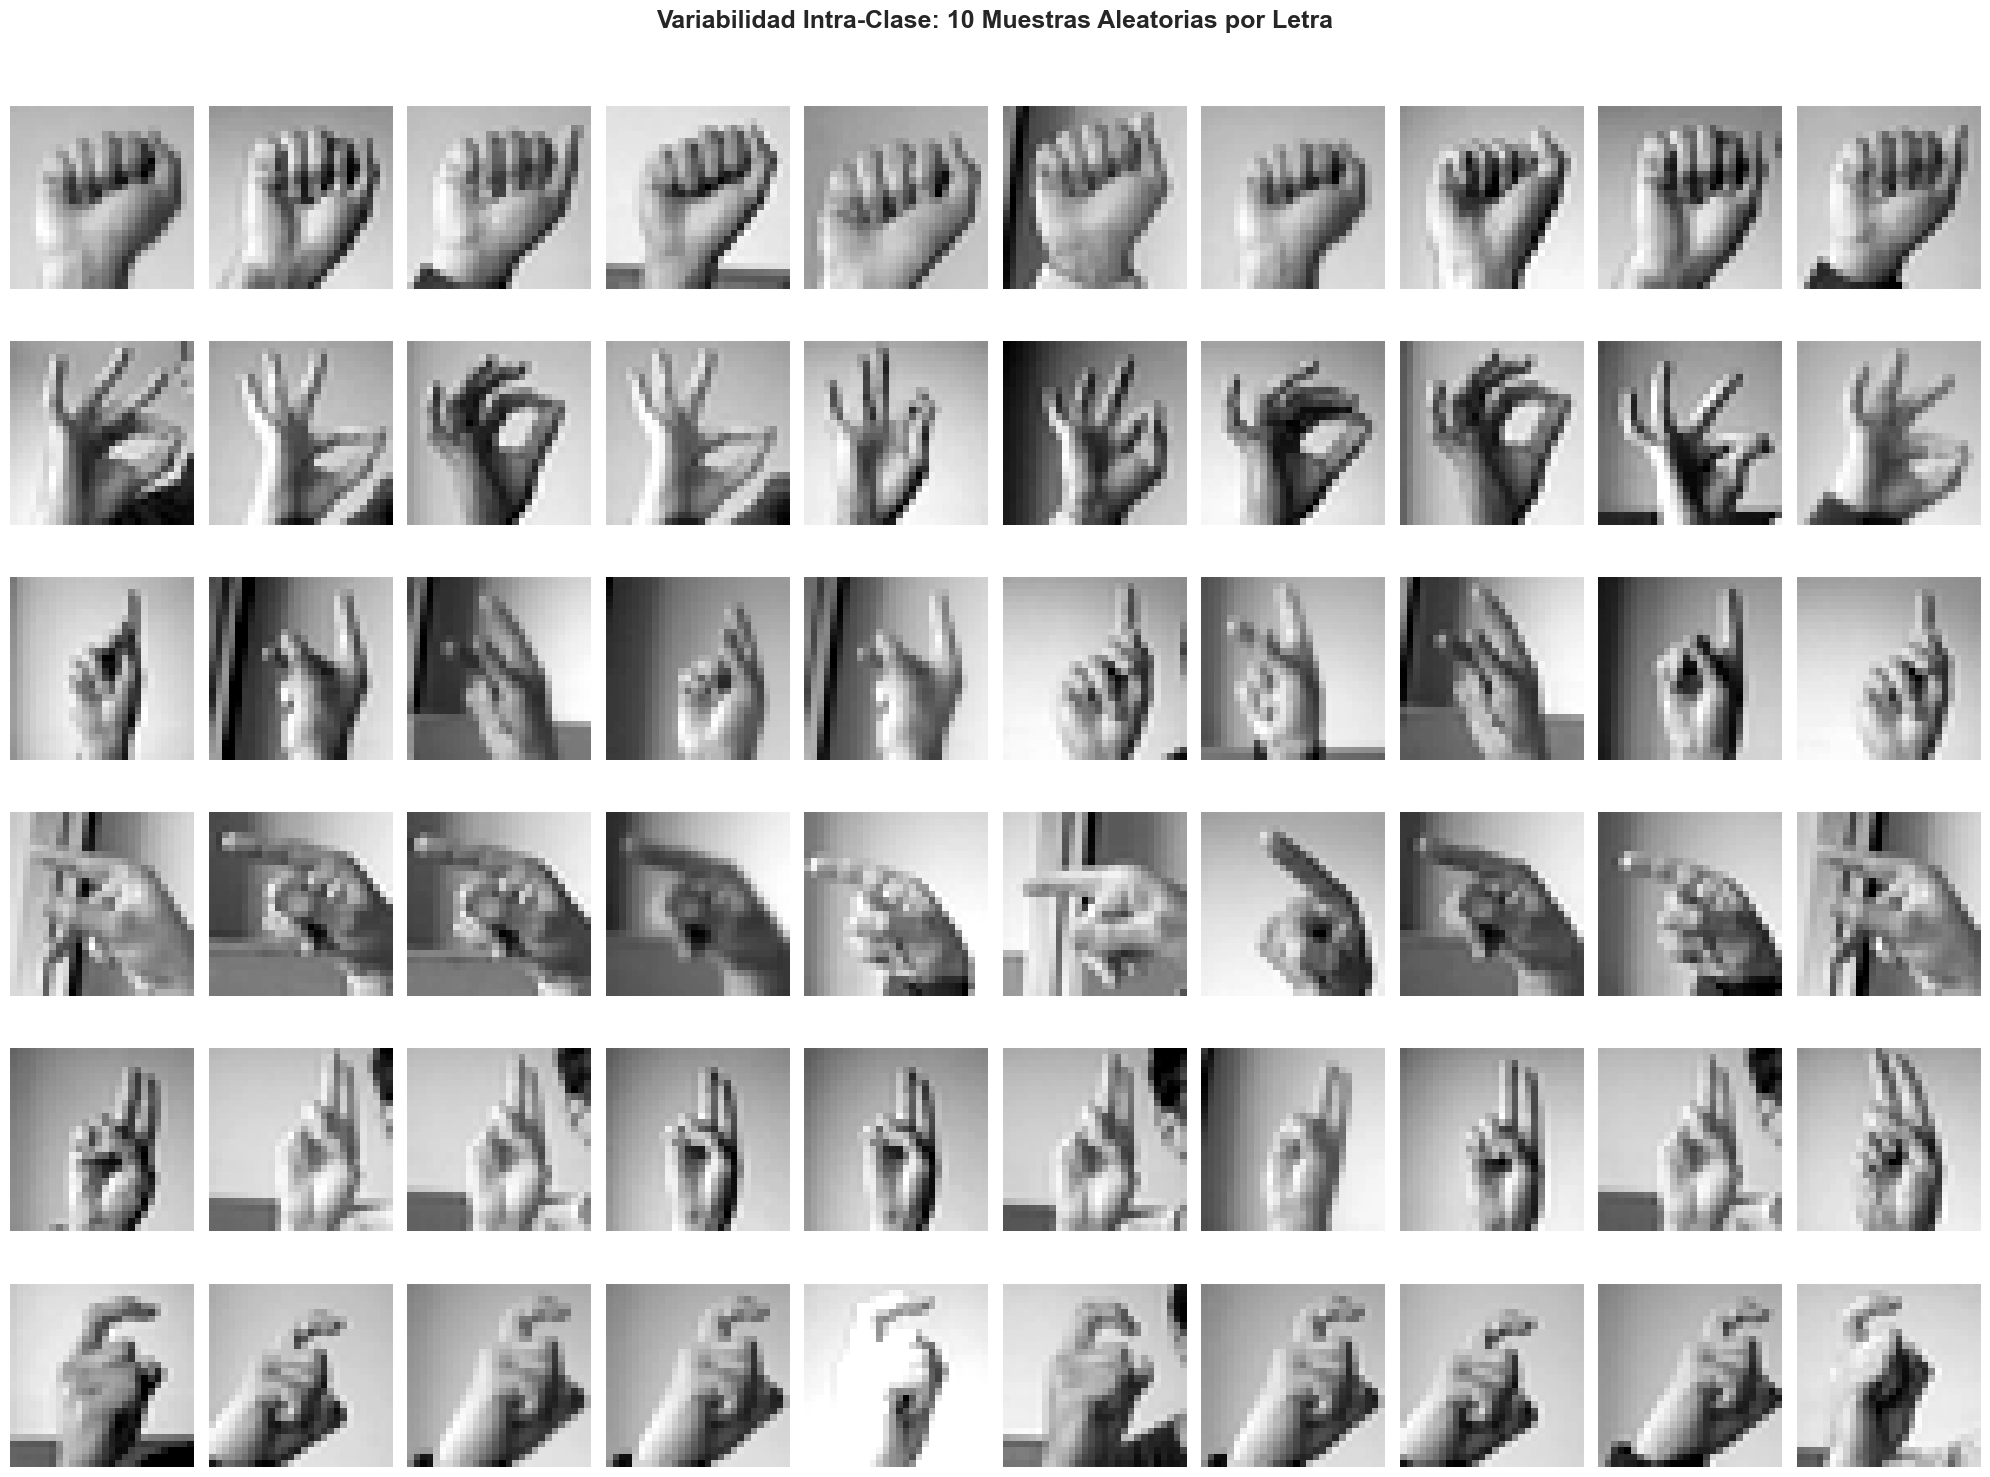

In [24]:
# Visualizar variabilidad intra-clase para algunas letras
selected_classes = [0, 5, 10, 15, 20, 23]  # A, F, L, Q, V, Y

fig, axes = plt.subplots(len(selected_classes), 10, figsize=(20, 2.5 * len(selected_classes)))

for i, class_idx in enumerate(selected_classes):
    class_images = X_train[y_train == class_idx]
    
    # Seleccionar 10 muestras aleatorias
    sample_indices = np.random.choice(len(class_images), 10, replace=False)
    
    for j, idx in enumerate(sample_indices):
        img = class_images[idx].reshape(28, 28)
        axes[i, j].imshow(img, cmap='gray')
        axes[i, j].axis('off')
        
        if j == 0:
            axes[i, j].set_ylabel(f'{label_to_letter[class_idx]}', fontsize=16, fontweight='bold', rotation=0, labelpad=20)

plt.suptitle('Variabilidad Intra-Clase: 10 Muestras Aleatorias por Letra', fontsize=18, fontweight='bold', y=1.005)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, '02_variabilidad_intra_clase.png'), dpi=200, bbox_inches='tight')
plt.show()

## 5. Análisis de Similitud Entre Clases

### 5.1 Matriz de Distancias entre Imágenes Promedio

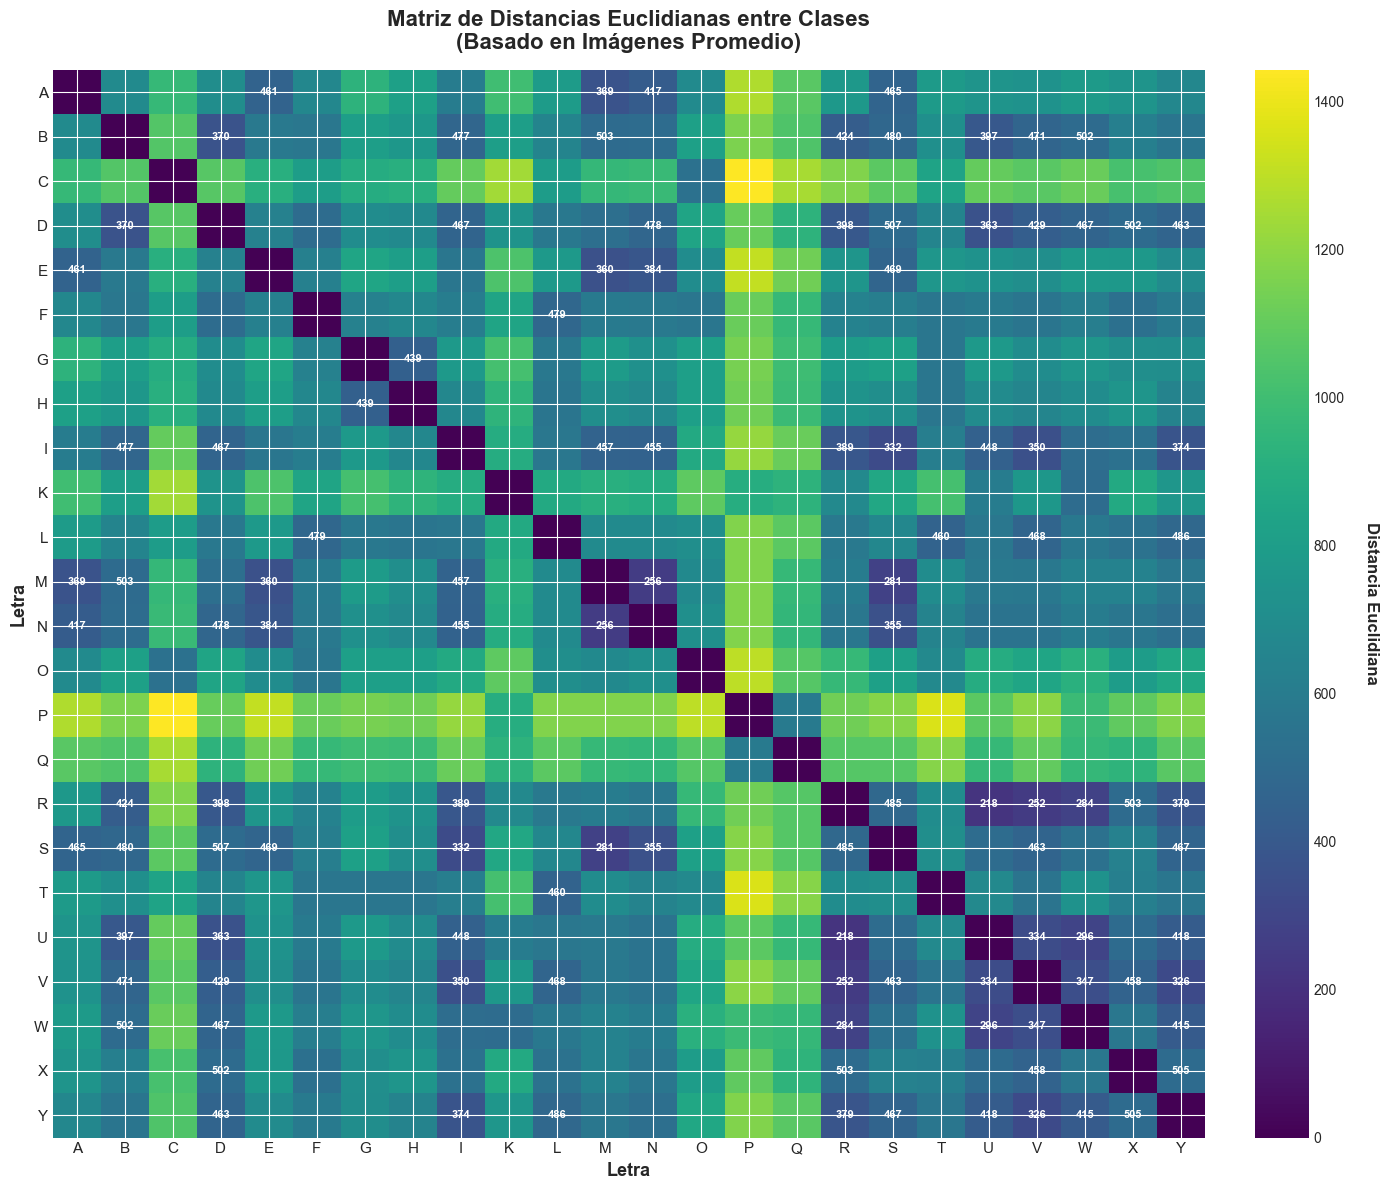


TOP 10 PARES DE CLASES MÁS SIMILARES
 1. R - U: Distancia = 217.71
 3. R - V: Distancia = 252.12
 5. M - N: Distancia = 256.03
 8. M - S: Distancia = 281.42
 9. R - W: Distancia = 284.25

Estos pares podrían ser confusos para el modelo de clasificación


In [26]:
# Calcular imágenes promedio de cada clase
class_means = np.array([X_train[y_train == i].mean(axis=0) for i in valid_labels])

# Calcular matriz de distancias (Euclidiana)
distance_matrix = pairwise_distances(class_means, metric='euclidean')

# Visualizar
fig, ax = plt.subplots(figsize=(14, 12))
letters = [label_to_letter[i] for i in valid_labels]
im = ax.imshow(distance_matrix, cmap='viridis', aspect='auto')
ax.set_xticks(np.arange(len(valid_labels)))
ax.set_yticks(np.arange(len(valid_labels)))
ax.set_xticklabels(letters, fontsize=11)
ax.set_yticklabels(letters, fontsize=11)
ax.set_title('Matriz de Distancias Euclidianas entre Clases\n(Basado en Imágenes Promedio)', 
             fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel('Letra', fontsize=13, fontweight='bold')
ax.set_ylabel('Letra', fontsize=13, fontweight='bold')

# Añadir colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Distancia Euclidiana', rotation=270, labelpad=25, fontsize=12, fontweight='bold')

# Añadir valores en cada celda (solo para valores pequeños - clases similares)
threshold = np.percentile(distance_matrix[distance_matrix > 0], 20)  # 20% más similares
for i in range(len(valid_labels)):
    for j in range(len(valid_labels)):
        if i != j and distance_matrix[i, j] < threshold:
            text = ax.text(j, i, f'{distance_matrix[i, j]:.0f}',
                         ha="center", va="center", color="white", fontsize=8, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, '02_matriz_distancias_clases.png'), dpi=200, bbox_inches='tight')
plt.show()

# Identificar pares de clases más similares
# Excluir diagonal
dist_no_diag = distance_matrix.copy()
np.fill_diagonal(dist_no_diag, np.inf)

# Top 10 pares más similares
print("\n" + "=" * 70)
print("TOP 10 PARES DE CLASES MÁS SIMILARES")
print("=" * 70)
sorted_indices = np.argsort(dist_no_diag.flatten())
for rank, idx in enumerate(sorted_indices[:10], 1):
    i, j = divmod(idx, len(valid_labels))
    if i < j:  # Evitar duplicados
        label_i = valid_labels[i]
        label_j = valid_labels[j]
        print(f"{rank:2d}. {label_to_letter[label_i]} - {label_to_letter[label_j]}: Distancia = {distance_matrix[i, j]:.2f}")
print("=" * 70)
print("\nEstos pares podrían ser confusos para el modelo de clasificación")

### 5.2 Dendrograma de Clustering Jerárquico

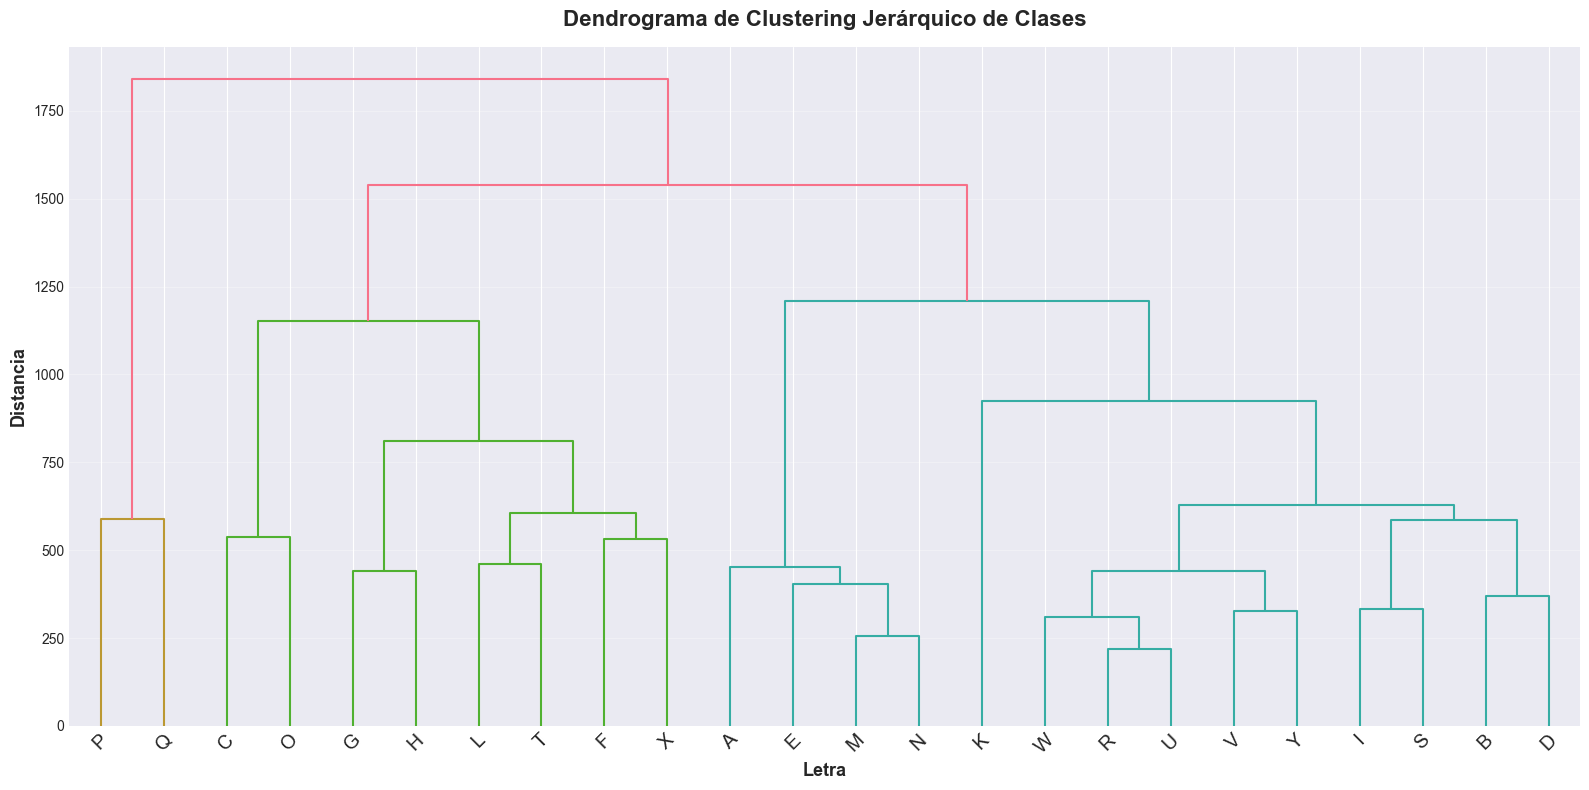


El dendrograma muestra qué letras son más similares visualmente
Las letras que se agrupan a baja distancia son más parecidas


In [27]:
# Realizar clustering jerárquico
linkage_matrix = linkage(class_means, method='ward')

# Visualizar dendrograma
plt.figure(figsize=(16, 8))
dendrogram(linkage_matrix, labels=letters, leaf_font_size=14)
plt.title('Dendrograma de Clustering Jerárquico de Clases', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Letra', fontsize=13, fontweight='bold')
plt.ylabel('Distancia', fontsize=13, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, '02_dendrograma_clustering.png'), dpi=200, bbox_inches='tight')
plt.show()

print("\nEl dendrograma muestra qué letras son más similares visualmente")
print("Las letras que se agrupan a baja distancia son más parecidas")

## 6. Reducción Dimensional y Visualización

### 6.1 Análisis de Componentes Principales (PCA)

ANÁLISIS DE COMPONENTES PRINCIPALES (PCA)
Dimensión original: 784 pixels

Componentes necesarios para:
  90% de varianza: 58 componentes
  95% de varianza: 115 componentes
  99% de varianza: 290 componentes

Varianza explicada por los primeros 10 componentes: 70.30%


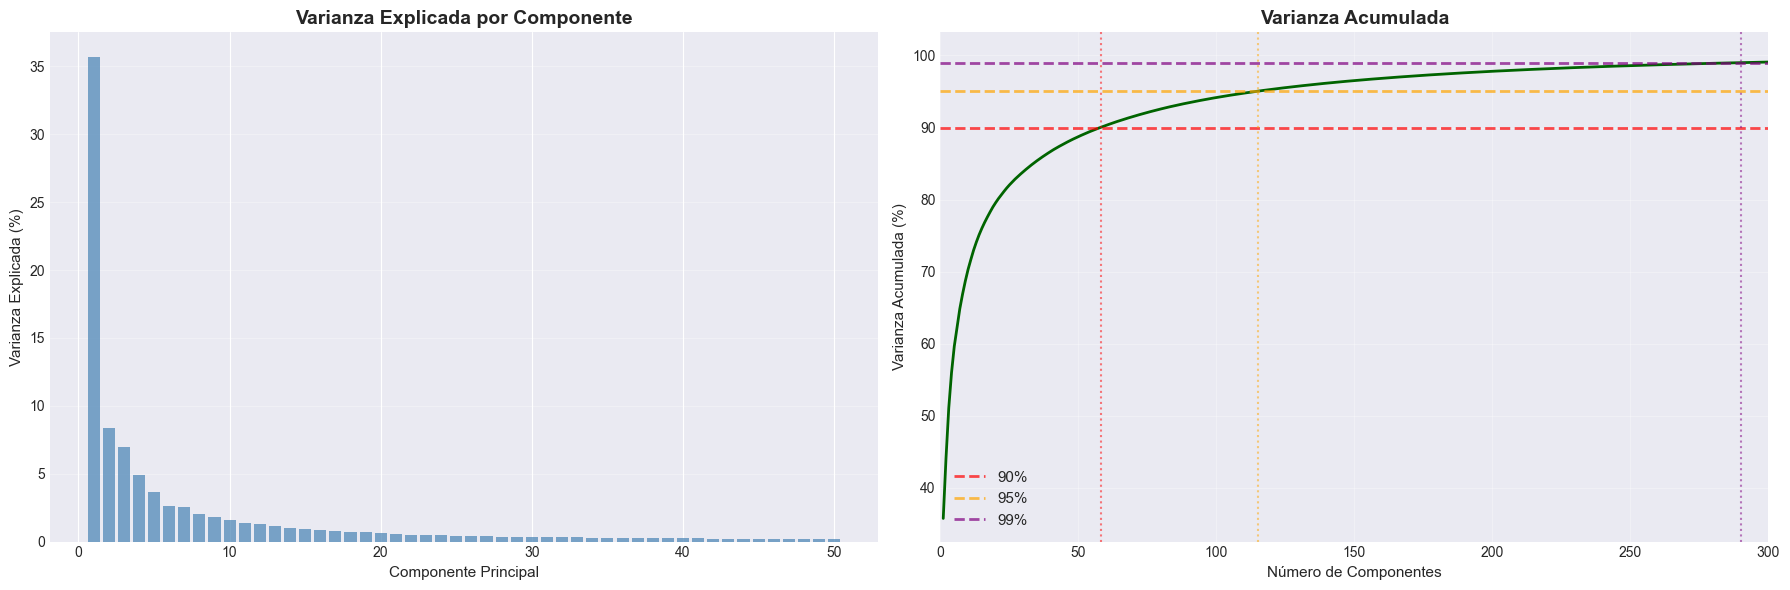

In [28]:
# Normalizar datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Aplicar PCA con todos los componentes
pca_full = PCA()
pca_full.fit(X_train_scaled)

# Análisis de varianza explicada
cumsum_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Encontrar número de componentes para diferentes niveles de varianza
n_components_90 = np.argmax(cumsum_variance >= 0.90) + 1
n_components_95 = np.argmax(cumsum_variance >= 0.95) + 1
n_components_99 = np.argmax(cumsum_variance >= 0.99) + 1

print("=" * 70)
print("ANÁLISIS DE COMPONENTES PRINCIPALES (PCA)")
print("=" * 70)
print(f"Dimensión original: {X_train.shape[1]} pixels")
print(f"\nComponentes necesarios para:")
print(f"  90% de varianza: {n_components_90} componentes")
print(f"  95% de varianza: {n_components_95} componentes")
print(f"  99% de varianza: {n_components_99} componentes")
print(f"\nVarianza explicada por los primeros 10 componentes: {cumsum_variance[9]*100:.2f}%")
print("=" * 70)

# Visualizar
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Varianza explicada
axes[0].bar(range(1, 51), pca_full.explained_variance_ratio_[:50] * 100, color='steelblue', alpha=0.7)
axes[0].set_title('Varianza Explicada por Componente', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Componente Principal', fontsize=11)
axes[0].set_ylabel('Varianza Explicada (%)', fontsize=11)
axes[0].grid(axis='y', alpha=0.3)

# Varianza acumulada
axes[1].plot(range(1, len(cumsum_variance) + 1), cumsum_variance * 100, linewidth=2, color='darkgreen')
axes[1].axhline(y=90, color='red', linestyle='--', linewidth=2, alpha=0.7, label='90%')
axes[1].axhline(y=95, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='95%')
axes[1].axhline(y=99, color='purple', linestyle='--', linewidth=2, alpha=0.7, label='99%')
axes[1].axvline(x=n_components_90, color='red', linestyle=':', alpha=0.5)
axes[1].axvline(x=n_components_95, color='orange', linestyle=':', alpha=0.5)
axes[1].axvline(x=n_components_99, color='purple', linestyle=':', alpha=0.5)
axes[1].set_title('Varianza Acumulada', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Número de Componentes', fontsize=11)
axes[1].set_ylabel('Varianza Acumulada (%)', fontsize=11)
axes[1].set_xlim([0, 300])
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, '02_pca_varianza.png'), dpi=200, bbox_inches='tight')
plt.show()

### 6.2 Visualización PCA 2D y 3D

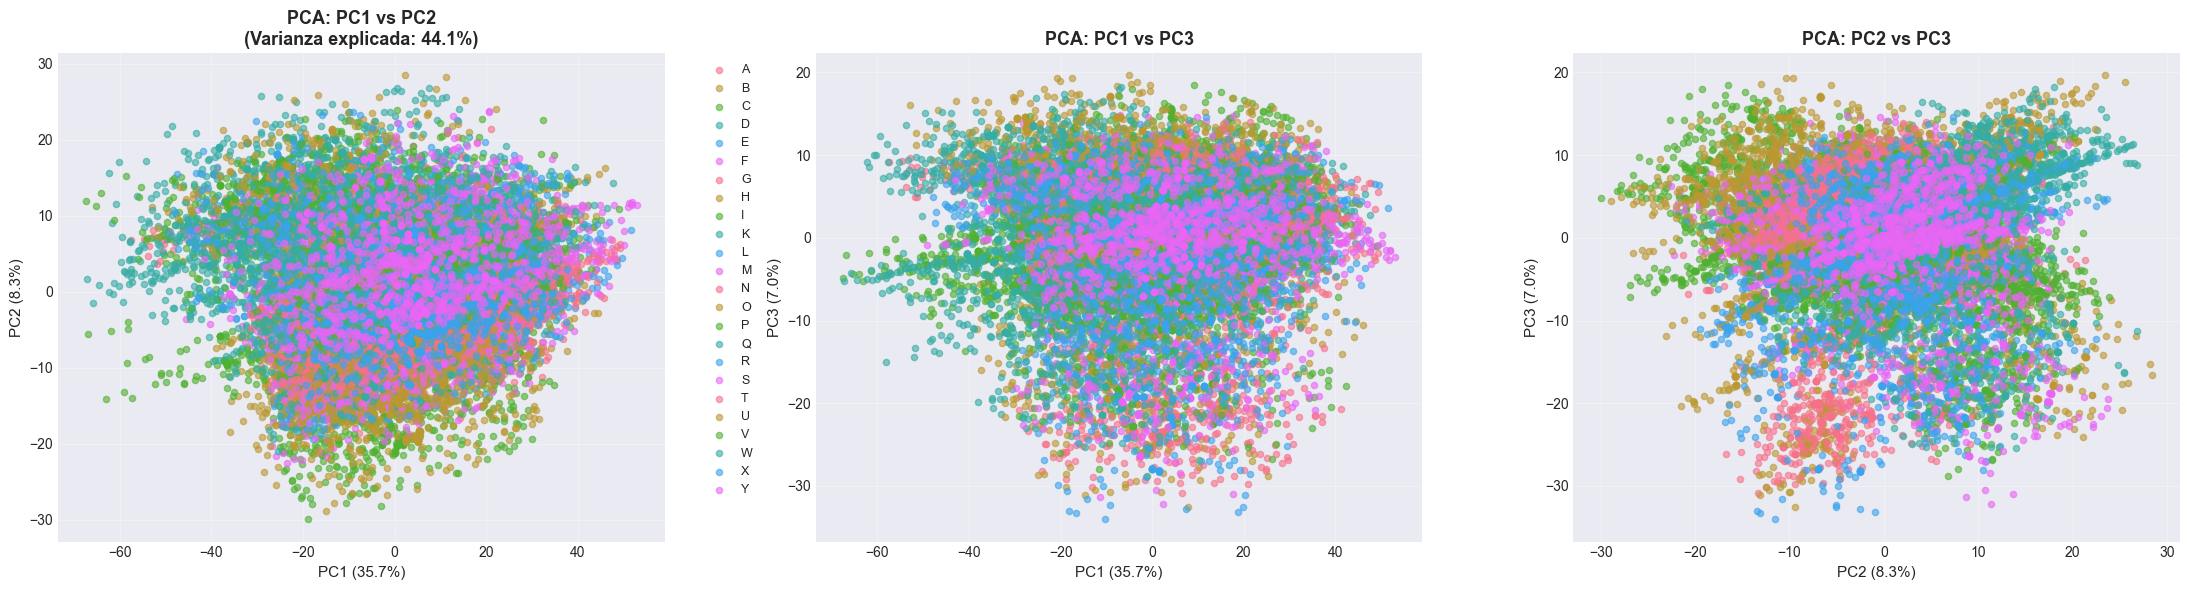

In [34]:
# PCA a 3 componentes
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_train_scaled)

# Crear DataFrame para visualización
pca_df = pd.DataFrame({
    'PC1': X_pca_3d[:, 0],
    'PC2': X_pca_3d[:, 1],
    'PC3': X_pca_3d[:, 2],
    'Letra': [label_to_letter[label] for label in y_train]
})

# Visualización 2D
fig, axes = plt.subplots(1, 3, figsize=(22, 6))

# PC1 vs PC2
for label in valid_labels:
    mask = y_train == label
    axes[0].scatter(X_pca_3d[mask, 0], X_pca_3d[mask, 1], 
                   label=label_to_letter[label], alpha=0.6, s=20)
axes[0].set_title(f'PCA: PC1 vs PC2\n(Varianza explicada: {pca_3d.explained_variance_ratio_[:2].sum()*100:.1f}%)',
                 fontsize=13, fontweight='bold')
axes[0].set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]*100:.1f}%)', fontsize=11)
axes[0].set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]*100:.1f}%)', fontsize=11)
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1, fontsize=9)
axes[0].grid(alpha=0.3)

# PC1 vs PC3
for label in valid_labels:
    mask = y_train == label
    axes[1].scatter(X_pca_3d[mask, 0], X_pca_3d[mask, 2], 
                   label=label_to_letter[label], alpha=0.6, s=20)
axes[1].set_title(f'PCA: PC1 vs PC3',
                 fontsize=13, fontweight='bold')
axes[1].set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]*100:.1f}%)', fontsize=11)
axes[1].set_ylabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]*100:.1f}%)', fontsize=11)
axes[1].grid(alpha=0.3)

# PC2 vs PC3
for label in valid_labels:
    mask = y_train == label
    axes[2].scatter(X_pca_3d[mask, 1], X_pca_3d[mask, 2], 
                   label=label_to_letter[label], alpha=0.6, s=20)
axes[2].set_title(f'PCA: PC2 vs PC3',
                 fontsize=13, fontweight='bold')
axes[2].set_xlabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]*100:.1f}%)', fontsize=11)
axes[2].set_ylabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]*100:.1f}%)', fontsize=11)
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, '02_pca_2d.png'), dpi=200, bbox_inches='tight')
plt.show()

## 7. Análisis de Características Visuales

### 7.1 Detección de Bordes (Sobel)

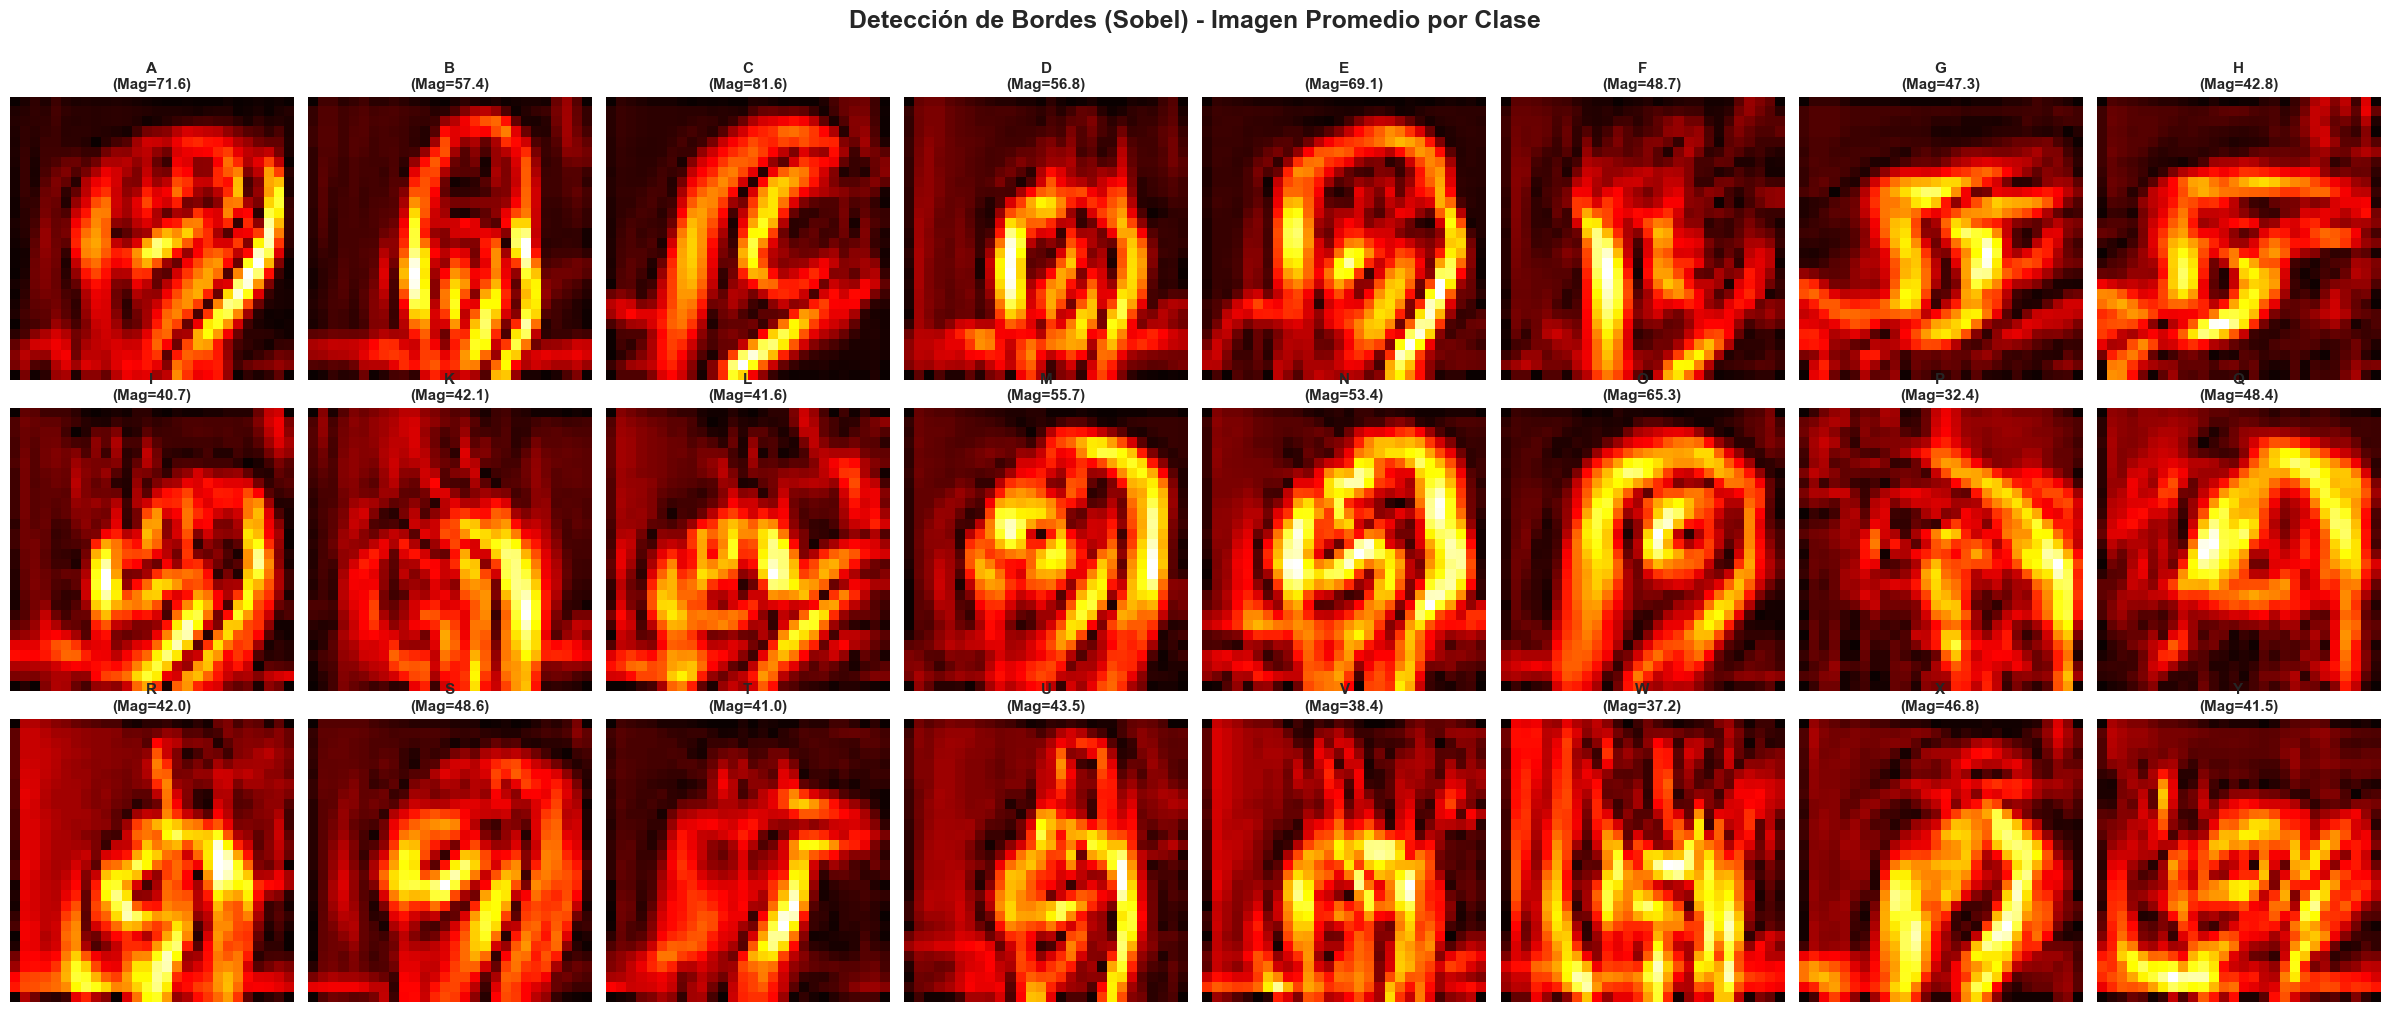

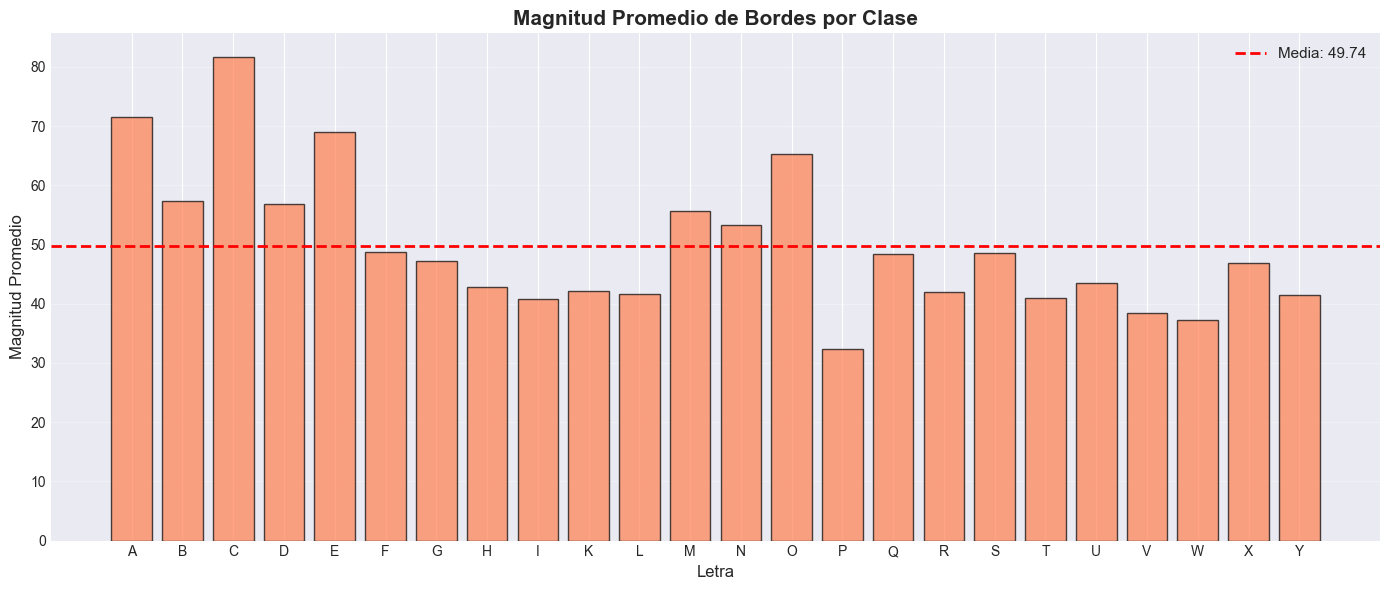

In [31]:
# Calcular magnitud promedio de bordes por clase
fig, axes = plt.subplots(3, 8, figsize=(24, 10))
axes = axes.ravel()

edge_magnitudes = []

for idx, label in enumerate(valid_labels):
    class_images = X_train[y_train == label]
    
    # Calcular bordes para imagen promedio
    avg_img = class_images.mean(axis=0).reshape(28, 28).astype(np.uint8)
    
    # Sobel
    sobelx = cv2.Sobel(avg_img, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(avg_img, cv2.CV_64F, 0, 1, ksize=3)
    sobel_magnitude = np.sqrt(sobelx**2 + sobely**2)
    
    edge_magnitudes.append(sobel_magnitude.mean())
    
    # Visualizar
    im = axes[idx].imshow(sobel_magnitude, cmap='hot')
    axes[idx].set_title(f'{label_to_letter[label]}\n(Mag={sobel_magnitude.mean():.1f})', 
                     fontsize=11, fontweight='bold')
    axes[idx].axis('off')

plt.suptitle('Detección de Bordes (Sobel) - Imagen Promedio por Clase', 
             fontsize=18, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, '02_deteccion_bordes.png'), dpi=200, bbox_inches='tight')
plt.show()

# Comparar magnitud de bordes entre clases
plt.figure(figsize=(14, 6))
letters = [label_to_letter[i] for i in valid_labels]
plt.bar(letters, edge_magnitudes, color='coral', alpha=0.7, edgecolor='black')
plt.axhline(np.mean(edge_magnitudes), color='red', linestyle='--', linewidth=2, 
           label=f'Media: {np.mean(edge_magnitudes):.2f}')
plt.title('Magnitud Promedio de Bordes por Clase', fontsize=15, fontweight='bold')
plt.xlabel('Letra', fontsize=12)
plt.ylabel('Magnitud Promedio', fontsize=12)
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, '02_magnitud_bordes_por_clase.png'), dpi=200, bbox_inches='tight')
plt.show()

### 7.2 Análisis de Momentos de Hu (Invariantes Geométricos)

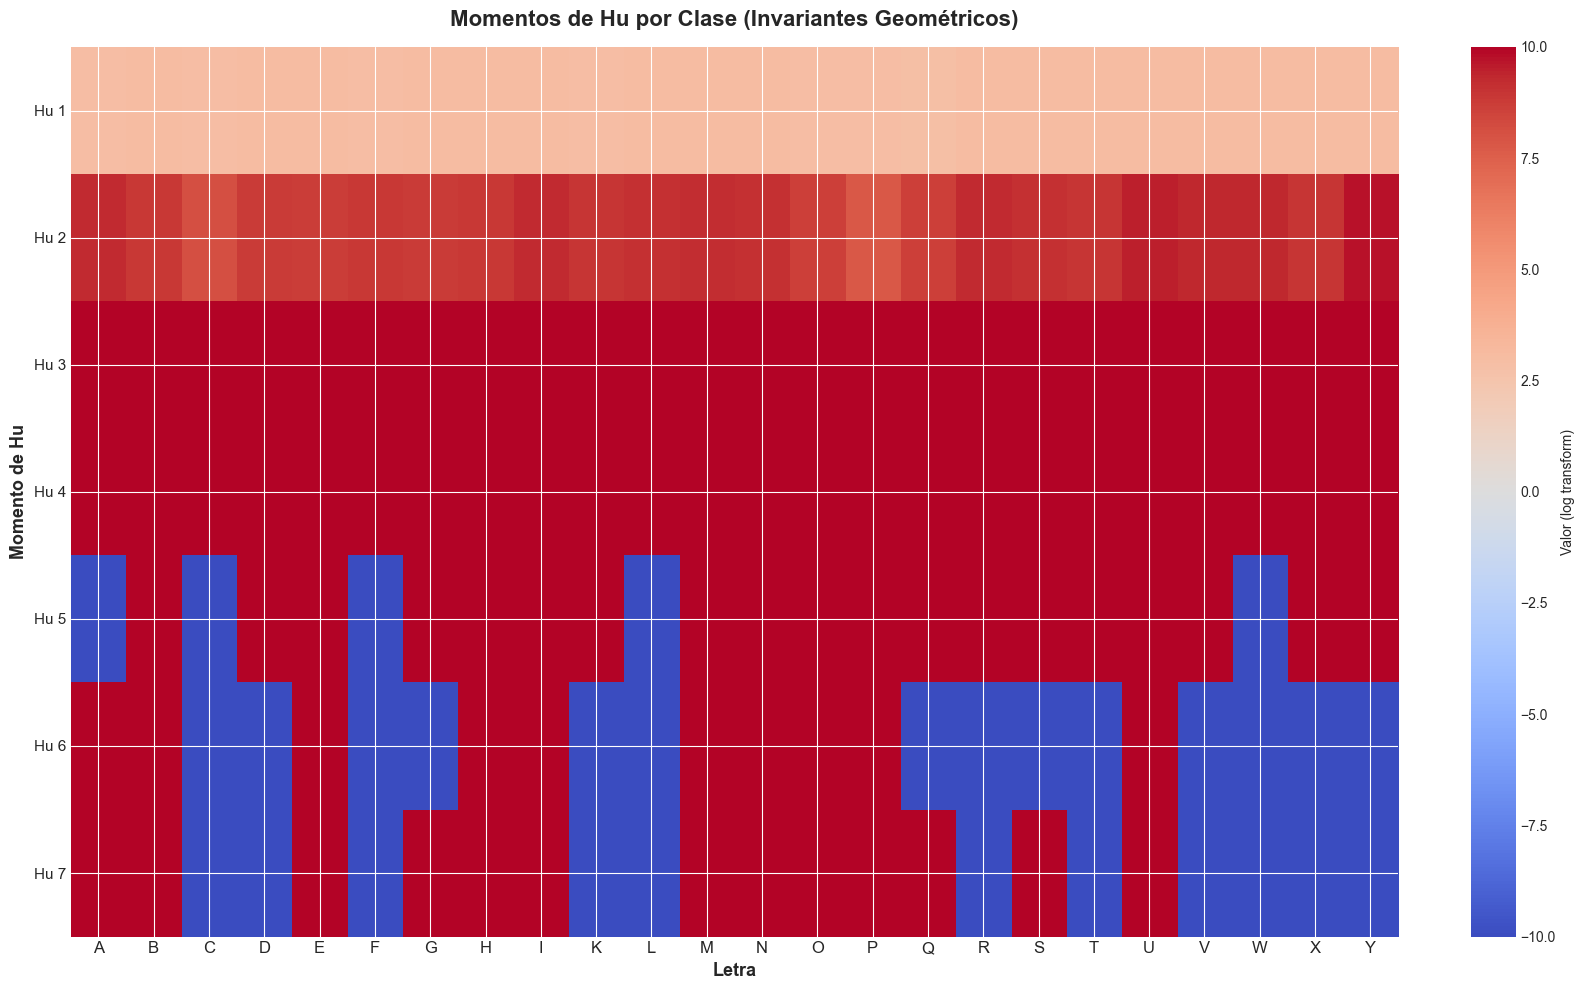


Los momentos de Hu son invariantes a translación, escala y rotación.
Útiles para caracterizar formas geométricas de las señas.


In [32]:
# Calcular momentos de Hu para cada clase
hu_moments_by_class = []

for label in valid_labels:
    class_images = X_train[y_train == label]
    avg_img = class_images.mean(axis=0).reshape(28, 28).astype(np.uint8)
    
    # Calcular momentos
    moments = cv2.moments(avg_img)
    hu_moments = cv2.HuMoments(moments).flatten()
    
    # Log transform para mejor visualización
    hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-10)
    
    hu_moments_by_class.append(hu_moments)

hu_moments_by_class = np.array(hu_moments_by_class)

# Visualizar
fig, ax = plt.subplots(figsize=(16, 10))
im = ax.imshow(hu_moments_by_class.T, cmap='coolwarm', aspect='auto')
ax.set_xticks(np.arange(len(valid_labels)))
ax.set_yticks(np.arange(7))
ax.set_xticklabels([label_to_letter[i] for i in valid_labels], fontsize=12)
ax.set_yticklabels([f'Hu {i+1}' for i in range(7)], fontsize=11)
ax.set_title('Momentos de Hu por Clase (Invariantes Geométricos)', 
             fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel('Letra', fontsize=13, fontweight='bold')
ax.set_ylabel('Momento de Hu', fontsize=13, fontweight='bold')
plt.colorbar(im, ax=ax, label='Valor (log transform)', fraction=0.046)

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, '02_momentos_hu.png'), dpi=200, bbox_inches='tight')
plt.show()

print("\nLos momentos de Hu son invariantes a translación, escala y rotación.")
print("Útiles para caracterizar formas geométricas de las señas.")

## 8. Detección de Outliers y Anomalías

DETECCIÓN DE OUTLIERS (Isolation Forest)
Total de muestras: 27,455
Outliers detectados: 275 (1.00%)


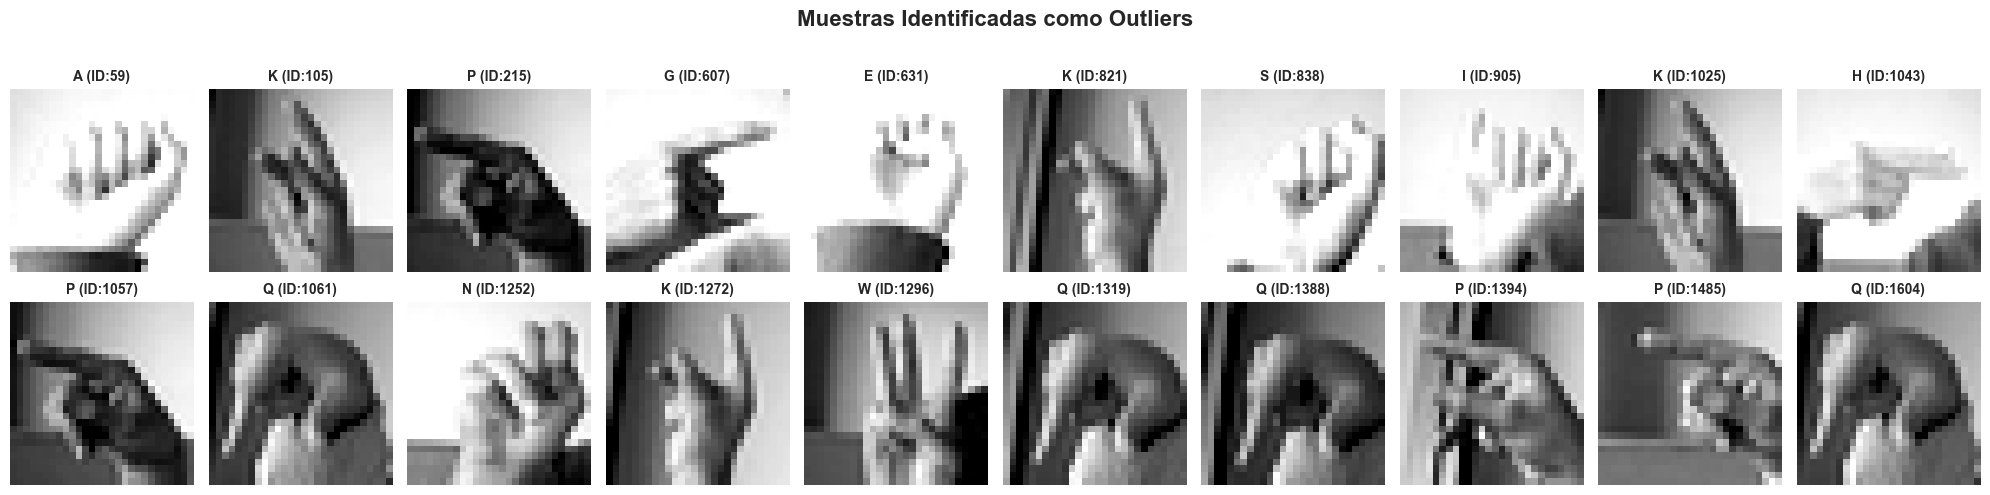

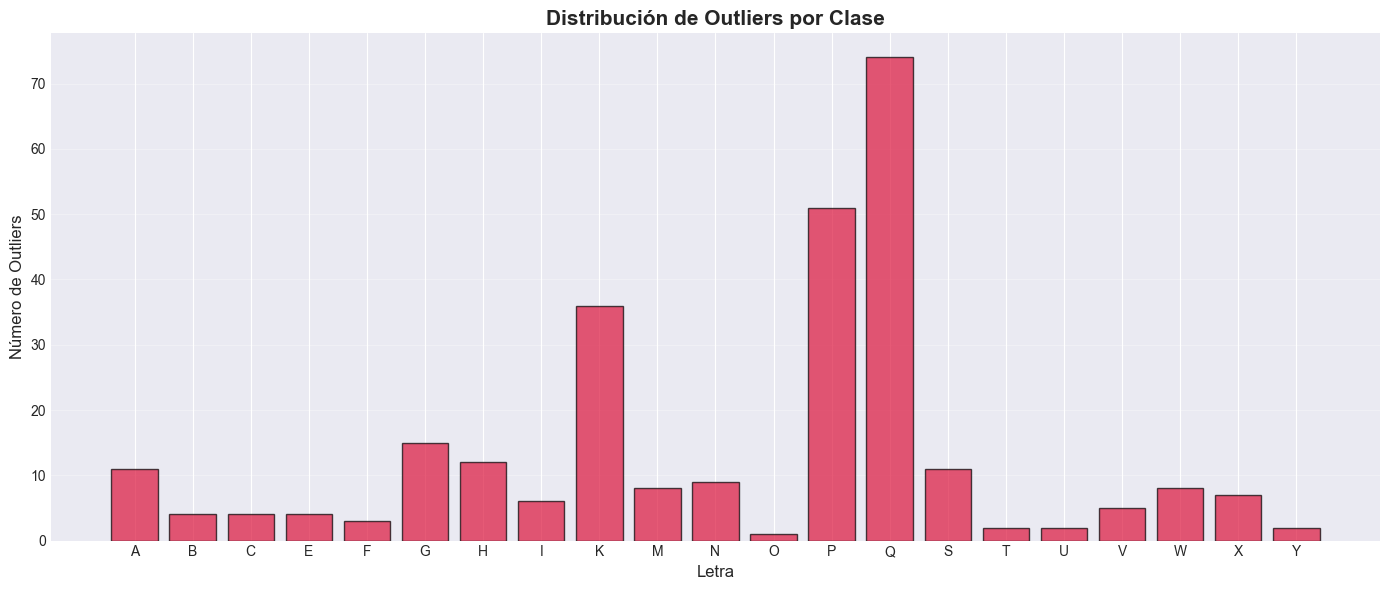

In [33]:
from sklearn.ensemble import IsolationForest

# Usar Isolation Forest para detectar outliers
iso_forest = IsolationForest(contamination=0.01, random_state=42)
outlier_predictions = iso_forest.fit_predict(X_train_scaled)

# -1 indica outlier, 1 indica normal
outlier_indices = np.where(outlier_predictions == -1)[0]
n_outliers = len(outlier_indices)

print("="*70)
print("DETECCIÓN DE OUTLIERS (Isolation Forest)")
print("="*70)
print(f"Total de muestras: {len(X_train):,}")
print(f"Outliers detectados: {n_outliers:,} ({n_outliers/len(X_train)*100:.2f}%)")
print("="*70)

# Visualizar algunos outliers
n_display = min(20, n_outliers)
fig, axes = plt.subplots(2, 10, figsize=(20, 5))
axes = axes.ravel()

for i, idx in enumerate(outlier_indices[:n_display]):
    img = X_train[idx].reshape(28, 28)
    label = y_train[idx]
    letter = label_to_letter[label]
    
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'{letter} (ID:{idx})', fontsize=10, fontweight='bold')
    axes[i].axis('off')

plt.suptitle('Muestras Identificadas como Outliers', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, '02_outliers.png'), dpi=200, bbox_inches='tight')
plt.show()

# Análisis de distribución de outliers por clase
outlier_labels = y_train[outlier_indices]
outlier_counts = pd.Series(outlier_labels).value_counts().sort_index()

plt.figure(figsize=(14, 6))
plt.bar([label_to_letter[i] for i in outlier_counts.index], 
        outlier_counts.values, color='crimson', alpha=0.7, edgecolor='black')
plt.title('Distribución de Outliers por Clase', fontsize=15, fontweight='bold')
plt.xlabel('Letra', fontsize=12)
plt.ylabel('Número de Outliers', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, '02_outliers_por_clase.png'), dpi=200, bbox_inches='tight')
plt.show()